# Introduction to NLP: Final Project

Group members: 
- Oliver Gatland
- Angelo Di Gianvito
- Sebastien Boxho

## Project:  "Utilizing NLP Techniques for Job Search and Career Guidance in Economics  and Data Science: Intelligent Matching of CVs with Job Offers" 

Project description: ...

In [6]:
import os
import re
import sys
import nltk
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from collections import Counter
from IPython.display import display, HTML
from concurrent.futures import ThreadPoolExecutor

# ML Functions
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# NLP functions
from datasets import load_dataset
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
from wordcloud import WordCloud
import docx2txt
import requests
import subprocess
from gensim.models.coherencemodel import CoherenceModel
from tabulate import tabulate
# from textblob import TextBlob
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
from langdetect import detect
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#!python -m spacy download en_core_web_sm
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
sp = spacy.load('en_core_web_sm')

from src.preprocessing import *

lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

import warnings
# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing and EDA

To improve the readability of this Notebook some of the preprocessing functions used in the coming cells are imported from the preprocessing.py file.

### Importing data

In [7]:
path_jobs_indeed = './data/job_postings/indeed_scrapped_jobs.csv'
path_cv = './data/cv/Resume Screening.csv'
# TODO: Model: SpaCY matcher
# TODO: Resampling: SMOTE
# TODO: Resume add noise (Others)
# TODO: When train on extracted drop missing vals
# TODO: Change name of Cosine model to Group model
# TODO: Tidy up the scrapper
data_resume = pd.read_csv(path_cv)
df_resume = pd.DataFrame(data_resume)
data_jobs = pd.read_csv(path_jobs_indeed)
df_jobs = pd.DataFrame(data_jobs) 
print("Shape of resume: ",df_resume.shape)
print("Shape of jobs: ",df_jobs.shape)

Shape of resume:  (962, 2)
Shape of jobs:  (2160, 6)


In [8]:
df_jobs.head()

,Job title,Company,Description,Job_Title_Searched,Location_Searched,Location
0,Data Analyst,UCLA,About the California Policy Lab\nThe Californi...,Data Science,Los Angeles,"Los Angeles, CA"
1,Research Data Scientist,CEDARS-SINAI,Job Description\nThe Research Data Scientist p...,Data Science,Los Angeles,"Los Angeles, CA"
2,Data Scientist,NaN,Expatiate Communications is a boutique managem...,Data Science,Los Angeles,"Pasadena, CA"
3,DATA SCIENTIST,Los Angeles County Department of Human Resources,EXAM NUMBER:\nPH1763B\n\nTYPE OF RECRUITMENT:\...,Data Science,Los Angeles,"Los Angeles County, CA"
4,Predictive Data Analyst - CalAIM,Heluna Health,Salary: $42.59 - $57.40 Per Hour\nSUMMARY\nCom...,Data Science,Los Angeles,"Los Angeles, CA 90014"


In [9]:
df_resume.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


# TEST SpaCY ! 

In [10]:
"""# SPACY TEST:
import spacy
from spacy.matcher import Matcher

# Load the SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Lists of words indicating the start and end of the useful information
des_begin = ['what you can expect in this role', 'what you should bring', 'job description', 'as a', 'in this role you will',
             'the work will require', 'you are going to', 'what you ll do', 'what you will do', 'what will you do',
             'what we re looking for', 'we are looking for', 'we re looking for', 'what we are looking for',
             'typical day in role', 'what you ll be doing', 'you will be working', 'you ll be working', 'job details',
             'responsibilities', 'your responsibilities', 'key responsibilities', 'main responsibilities',
             'key qualifications', 'minimum qualifications', 'minimum requirements', 'your profile', 'your role',
             'about the job', 'about you', 'about the opportunity', 'about this opportunity', 'your mission',
             'we are seeking', 'we offer', 'tasks associated to this job']

des_end = ['we are proud', 'our mission', 'proud to be', 'we truly believe', 'what you ll benefit',
           'for more information', 'for more info', 'share this', 'share this job', 'discover our', 'follow us',
           'we welcome applicants', 'if you think you have', 'we believe', 'we do not discriminate', 'discriminate',
           'equal opportunity', 'additional information', 'equal employment opportunity', 'find out more about',
           'find out more', 'build a better future', 'want to know more', 'know more', 'who we are', 'what do we offer',
           'what we offer', 'for enquiry', 'about us', 'affirmative action', 'what you ll find', 'data protection policy',
           'personal data protection policy', 'personal data protection', 'if you think you', 'we offer you',
           'we invite you', 'what you will have', 'what you will get', 'flexible hours', 'multicultural work environment',
           'race', 'color', 'religion', 'sex', 'disability', 'sexual orientation', 'to submit your application', 'benefits',
           'we are looking forward', 'apply now', 'insurance', 'location', 'where you will work', 'where it will be',
           'if you are']

# Create a Matcher object
matcher = Matcher(nlp.vocab)

# Define patterns for the useful information
useful_info_patterns = [
    [{"LOWER": {"in": des_begin}}, {"OP": "*"}, {"LOWER": {"in": des_end}}],
    [{"LOWER": {"in": des_begin}}, {"LOWER": {"NOT_IN": des_end}}, {"OP": "*"}, {"LOWER": {"in": des_end}}],
]

#[{"LOWER": {"in": des_begin}}, {"LOWER": "experience"}, {"OP": "*"}, {"LOWER": {"in": des_end}}],
#[{"LOWER": {"in": des_begin}}, {"LOWER": "education"}, {"OP": "*"}, {"LOWER": {"in": des_end}}],
#[{"LOWER": {"in": des_begin}}, {"POS": "NOUN", "OP": "+"}, {"OP": "*"}, {"LOWER": {"in": des_end}}]

# Add patterns to the matcher
for pattern in useful_info_patterns:
    matcher.add("useful_info", [pattern])

# Example text (replace this with your actual job offer text)
job_offer_text = df['description'][2]

# Process the text with SpaCy
doc = nlp(job_offer_text)

# Use the matcher to find matches in the text
matches = matcher(doc)

# Extract the matched spans
extracted_info = []
for match_id, start, end in matches:
    span = doc[start:end]
    extracted_info.append(span.text)

# Print the extracted information
print("Extracted Information:")
for info in extracted_info:
    print(info)
"""

'# SPACY TEST:\nimport spacy\nfrom spacy.matcher import Matcher\n\n# Load the SpaCy English model\nnlp = spacy.load("en_core_web_sm")\n\n# Lists of words indicating the start and end of the useful information\ndes_begin = [\'what you can expect in this role\', \'what you should bring\', \'job description\', \'as a\', \'in this role you will\',\n             \'the work will require\', \'you are going to\', \'what you ll do\', \'what you will do\', \'what will you do\',\n             \'what we re looking for\', \'we are looking for\', \'we re looking for\', \'what we are looking for\',\n             \'typical day in role\', \'what you ll be doing\', \'you will be working\', \'you ll be working\', \'job details\',\n             \'responsibilities\', \'your responsibilities\', \'key responsibilities\', \'main responsibilities\',\n             \'key qualifications\', \'minimum qualifications\', \'minimum requirements\', \'your profile\', \'your role\',\n             \'about the job\', \'abo

## Preprocessing

For now we will just apply lowercasing and remove the special characters (also numbers), there will be further preprocessing in following steps.

In [11]:
print("Shape of resume: ",df_resume.shape)
print("Shape of jobs (before): ",df_jobs.shape)
# Only keep the relevant columns
df_jobs = df_jobs[['Job_Title_Searched', 'Description']]

#Drop the rows with missing values
df_jobs = df_jobs.dropna()

# Preprocess the categorical data
# modulation: 0 -> remove stop words, 1 -> remove stop words and stem words, 2 -> remove stop words and lemmatize words
df_jobs['cleaned_description'] = df_jobs['Description'].apply(remove_special_characters)
df_jobs["cleaned_description"] = df_jobs["cleaned_description"].apply(tokenize, modulation=0) 
df_resume['cleaned_resume'] = df_resume['Resume'].apply(remove_special_characters)
df_resume["cleaned_resume"] = df_resume["cleaned_resume"].apply(tokenize, modulation=0)

print("Shape of jobs (after): ",df_jobs.shape)

Shape of resume:  (962, 2)
Shape of jobs (before):  (2160, 6)


Shape of jobs (after):  (2149, 3)


## Parsing Descriptions

### Extract job content from Description
In the Job descriptions the corpus is usually composed by a description of the company, the body which includes the content of the job (what we are most interested in) and a final section including benefits or additional information.

We will extract the interesting information using a regex pattern that will cut the initial and the final section. This will inevitably decrease the number of available descriptions, but will ensure robust analysis which for our purpose is what we are mostly looking for.

The following variables contain the expressions to match to achieve the predefined goal. A regex pattern is then defined and applied to the descriptions.

new rules applied that decreased the number of matches by around 30 percent: 

'we are proud' ,'our mission' ,'proud to be', 'we truly believe' , 'what you\'ll benefit',

In [12]:
# TODO: Maybe change these sentences
words_to_include = ['what you can expect in this role','what you should bring', 'kob description','as a','in this role you will', 'the work will require','you are going to','what you ll do','what you will do','what will you do', 'what we re looking for', 'we are looking for', 'we re looking for', 'what we are looking for', 'typical day in role', 'what you ll be doing', 'you will be working', 'you ll be working', 'job details', 'responsibilities', 'your responsibilities','key responsibilities', 'main responsibilities', 'key qualifications','minimum qualifications','minimum requirements' ,'your profile', 'your role', 'about the job', 'about you', 'about the opportunity','about this opportunity', 'your mission', 'we are seeking', 'we offer', 'tasks associated to this job']
words_to_exclude = ['we are proud' ,'our mission' ,'proud to be' , 'we truly believe' , 'what you ll benefit','for more information', 'for more info', 'share this', 'share this job', 'discover our', 'follow us', 'we welcome applicants', 'if you think you have', 'we believe', 'we do not discriminate', 'discriminate', 'equal opportunity', 'additional information', 'equal employment opportunity', 'find out more about','find out more', 'build a better future', 'want to know more', 'know more', 'who we are', 'what do we offer', 'what we offer','for enquiry', 'about us', 'affirmative action', 'what you ll find', 'data protection policy', 'personal data protection policy', 'personal data protection', 'if you think you', 'we offer you', 'we invite you','what you will have', 'what you will get', 'flexible hours', 'multicultural work environment', 'race', 'color', 'religion', 'sex', 'disability', 'sexual orientation', 'to submit your application', 'benefits', 'we are looking forward', 'apply now', 'insurance', 'location', 'where you will work', 'where it will be', 'if you are']

# Constructing a regex pattern to capture content after the first appearance of any specified word
regex_pattern = f"(?:{'|'.join(map(re.escape, words_to_include))})(.*?)(?:$)"

In [13]:
# Applying the regex pattern to extract job content only from the first appearance of a specified word
def extract_job_content(description):
    match = re.search(regex_pattern, description, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else np.nan

# Applying the extraction function to the DataFrame
df_jobs = df_jobs.copy()
df_jobs['cleaned_extracted_description'] = df_jobs['cleaned_description'].apply(extract_job_content)

# Excluding words
exclude_pattern = f"({'|'.join(map(re.escape, words_to_exclude))})(.*?$)"

# Applying the regex pattern to exclude content after specified words
def exclude_content(description):
    if pd.notna(description):  # Check for non-NaN values
        return re.sub(exclude_pattern, '', description, flags=re.IGNORECASE | re.DOTALL)
    else:
        return np.nan

df_jobs['cleaned_extracted_description'] = df_jobs['cleaned_extracted_description'].apply(exclude_content)

# Optionally, you can replace empty strings with NaN in the processed column
df_jobs['cleaned_extracted_description'].replace('', np.nan, inplace=True)
print(df_jobs.shape)

(2149, 4)


To improve the rules in the matcher the data that was not matched will be analyzed to apply some trial and error and improve the matching rules.

In [14]:
df_missing = df_jobs[df_jobs['cleaned_extracted_description'].isna()]
df_extracted = df_jobs.dropna()

In [15]:
print(f'Percentage of unmatched descriptions: {round((df_missing.shape[0])/(df_jobs.shape[0])*100, 2)}%')

Percentage of unmatched descriptions: 36.02%


### Job Titles in df_jobs

Number of different job titles: 12


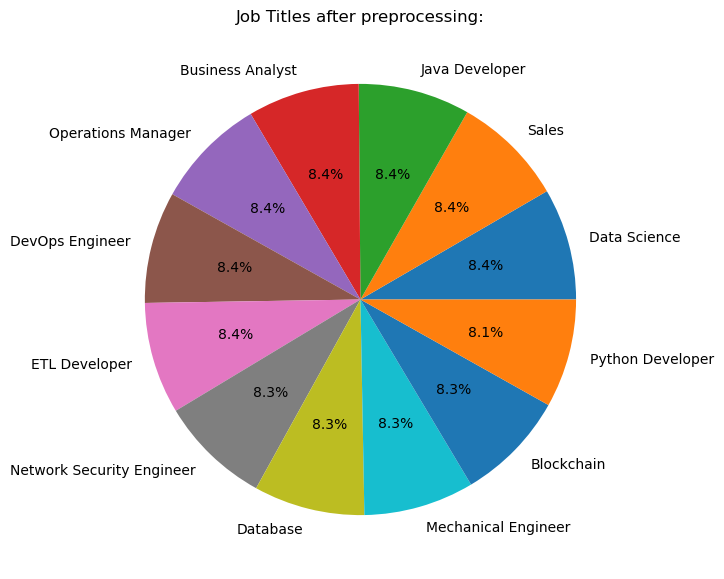

In [16]:
print(f'Number of different job titles: {df_jobs["Job_Title_Searched"].nunique()}')
job_title_freq = df_jobs['Job_Title_Searched'].value_counts().reset_index()
job_title_freq.columns = ['Job_Title_Searched', 'frequency']
# Plot pie chart of the 7 job titles
plt.figure(figsize=(10, 7))
plt.pie(job_title_freq['frequency'], labels=job_title_freq['Job_Title_Searched'], autopct='%1.1f%%')
plt.title('Job Titles after preprocessing:')
plt.show()

Comment graph...

### Preprocessing CV/Resume

In [17]:
df_resume['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

Example of a Resume:

In [18]:

print(df_resume['Category'][20])
print(df_resume['Resume'][20])

Data Science
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details 

Data Science Assurance Associate 

Data Science Assurance Associate - Ernst & Young LLP
Skill Details 
JAVASCRIPT- Exprience - 24 months
jQuery- Exprience - 24 months
Python- Exprience - 24 monthsCompany Details 
company - Ernst & Young LLP
description - Fraud Investigations and Dispute Ser

The resumes within the "Resume Screening" dataset exhibit a structured format, commencing with the Skills section, followed by Education, and concluding with the Experience section.

#### Job titles in df_resume

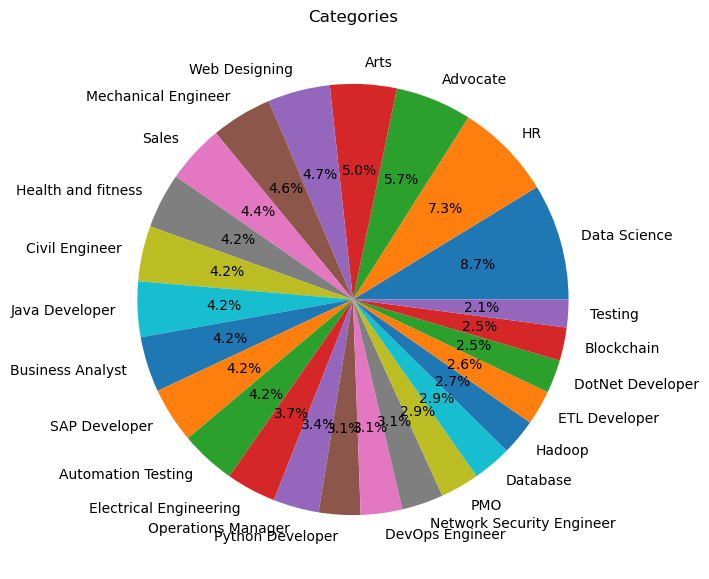

In [19]:
# Pie chart of the categories
plt.figure(figsize=(10, 7))
plt.pie(df_resume['Category'].value_counts(), labels=df_resume['Category'].unique(), autopct='%1.1f%%')
plt.title('Categories')
plt.show()

The resumes came with several different categories, some not related to the Data Science or technologies industry, will be dropped.

The remaining categories are then reduced to 12 job titles.

In [20]:
values_to_keep = ['Data Science','Mechanical Engineer', 'Sales','Java Developer', 'Business Analyst','Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'Database','Blockchain','ETL Developer']
df_resume['Category'] = df_resume['Category'].apply(lambda x: x if x in values_to_keep else 'NA')

"""# Select a random subset of 40 'NA' values -> 'Other
na_values = df_resume[df_resume['Category'] == 'NA']
random_subset = na_values.sample(n=40, random_state=42)
df_resume.loc[random_subset.index, 'Category'] = 'Other'"""

df_resume = df_resume[df_resume['Category'] != 'NA']
df_resume = df_resume.reset_index()
print("Total number of CVs: ", df_resume.shape[0])
print(df_resume['Category'].value_counts())

Total number of CVs:  513
Category
Java Developer               84
DevOps Engineer              55
Python Developer             48
Data Science                 40
Mechanical Engineer          40
Sales                        40
Operations Manager           40
ETL Developer                40
Blockchain                   40
Database                     33
Business Analyst             28
Network Security Engineer    25
Name: count, dtype: int64


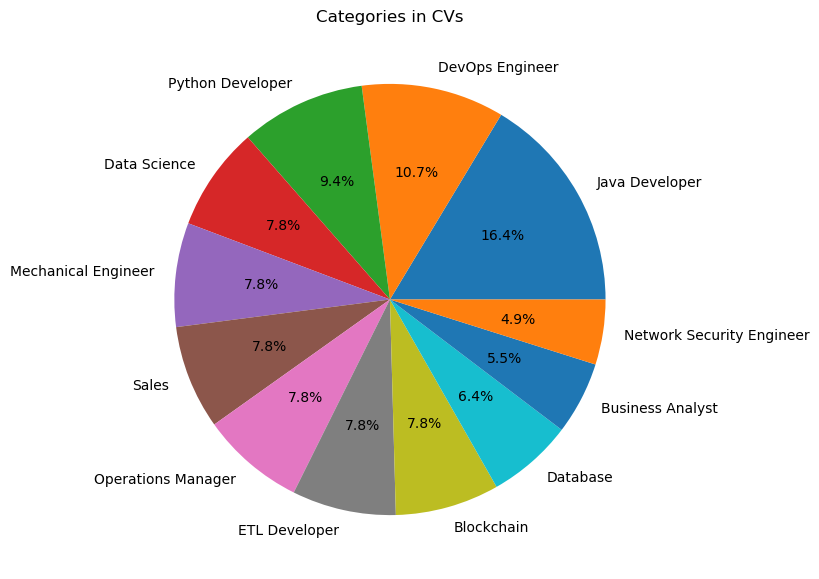

In [21]:
# Pie Chart of the categories in CVs
category_count = df_resume['Category'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%')
plt.title('Categories in CVs')
plt.show()

SImilar distribution of job titles as in the job offers dataset, main difference is the amount of Java Developers.

### Preprocessing (Resume Screening dataset):

In the resume dataset used for this project, most of the resumes follow a similar structure:
- Skills (not always present)
- Education Details
- Complete job title
- Skills Details -> Experience
- More details about experience/companies


In [22]:
df_resume['Experience'] = df_resume['cleaned_resume'].apply(lambda x: (x.split("skill details", 1)[1]))
df_resume['Skills'] = None
df_resume['Education'] = None

for i in range(len(df_resume)):
    educ_and_skills = df_resume['cleaned_resume'].iloc[i].split('skill details', 1)[0]
    educ = educ_and_skills.split('education details', 1)[1]
    skills = educ_and_skills.split('education details', 1)[0]
    df_resume['Skills'].iloc[i] = skills
    df_resume['Education'].iloc[i] = educ


In [23]:
# Replace empty strings with NaN in the 'Skills' and 'Education' columns
df_resume['Skills'].replace('', np.nan, inplace=True)
df_resume['Education'].replace('', np.nan, inplace=True)
# Print the columns and number of missing values
print("Missing values: ")
print(df_resume.isnull().sum())
print(df_resume.shape)

Missing values: 
index               0
Category            0
Resume              0
cleaned_resume      0
Experience          0
Skills            118
Education           0
dtype: int64
(513, 7)


### Creating id:

In [24]:
df_jobs['id'] = np.arange(0,len(df_jobs), 1)
df_extracted['id'] = np.arange(0,len(df_extracted), 1)
df_resume['id'] = np.arange(0,len(df_resume), 1)

# Skills extraction on jobs and resume dataset

Every job description has some specific skills that are required or requested. Depending on the job position these skills will change. Our objective is again to make clusters of job postings based on their description raher than the job titles. This practice will be enhanced by selecting the most required skills for each of the job clusters.

To extract the skills we used spacy's Named Entity Recognition. We trained our own model labeling part of our data detecting Hard and Soft skills in the descriptions. The model was then applied to extract the skills from each of the descriptions and stored in two separate columns for Hard and Soft skills.

In [25]:
# Specify the file path where you saved the dictionary
file_path = "./data/train_data_NER.pkl"

# Open the file in binary read mode and load the dictionary using pickle
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

In [26]:
nlp = spacy.load("en_core_web_sm")

db = DocBin()

for text, annot in tqdm(loaded_data['annotations']):
        # print(text)
        # print(annot)
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)

db.to_disk("./training_data_skills.spacy") 

100%|██████████| 201/201 [00:00<00:00, 839.73it/s] 


In [27]:
ner_model = spacy.load("./model-last") #load the best model
doc = ner_model("experienced software engineers who understand performance at scale, networking, storage and usability.applicants should be passionate about the future of ubuntu and be able to show technical leadership with a globally distributed team of engineers who share that passion. this position requires international travel several times a year.what you'll dodevelop maas core components and features to make maas the #1 bare metal cloud system.shape the architecture of maas to make it simpler, faster and easier to use.collaborate with other teams to ensure maas works well with other tools and is released on time.contribute your improvements to our continuous integration environment, tests and practices, to maintain fast feedback and good test coverage.contribute to documentation of current and existing features, making it world-class resource for data centre operators and users.provide technical communication and collaboration with other teams where appropriate.take personal ownership of problems and drive them to solutions.travel internationally a few times a year to meet and collaborate with your and other teams.who you areat least 5 years of proven professional software development experience in python, go or similar.capacity to learn quickly about new systems and techniquesexcellent logic, problem solving, and troubleshooting skillsstrong english language communication skills - both written and verbalexperience with linux server technologies, including but not limited to virtualization (kvm), containers (lxc), etc.you have a bachelor's or equivalent in computer science, stem or similar degreeknowledge of network technologies, including pxe, dhcp, tftp, dns, ntpsome experience with baseboard management controllers and protocols (redfish, ipmi, amt and others)strong experience with networking, storage technologies and cloud hosting and infrastructure.ideally, experience of large-scale physical server provisioning and automation, including rapid deployment, configuration, management and service orchestration.familiarity with some of the open source development tools and methodologies used in creation of several ubuntu projects (maas, juju, ubuntu server, lxd, ubuntu core), such as launchpad, debian packaging tools (apt, dpkg) and snapcraft.canonical is proud to foster a workplace free from discrimination. ") # input sample text

spacy.displacy.render(doc, style="ent", jupyter=True)

We can see from the random example that the model is detecting very well the hard and soft skills in the text. After testing the model on several examples and adding more labelled data we were satisfied with the performance and proceeded to the implementation.

In [28]:
# Load your trained model
nlp1 = spacy.load("./model-last")

# Assuming df_new is your DataFrame with the job descriptions
df_jobs['hard_skills'] = ''
df_jobs['soft_skills'] = ''
df_extracted['hard_skills'] = ''
df_extracted['soft_skills'] = ''
df_resume['hard_skills'] = ''
df_resume['soft_skills'] = ''

# Function to extract hard and soft skills from a text using the trained model
def extract_skills(text):
    doc = nlp1(text)
    # print(doc)
    hard_skills = []
    soft_skills = []
    for ent in doc.ents:
        if ent.label_ == 'HARD_SKILL':
            hard_skills.append(ent.text)
        elif ent.label_ == 'SOFT_SKILL':
            soft_skills.append(ent.text)
    return hard_skills, soft_skills

# Apply the function to each row in the Job DataFrame
for index, row in df_jobs.iterrows():
    text = row['cleaned_description']
    hard_skills, soft_skills = extract_skills(text)
    df_jobs.at[index, 'hard_skills'] = hard_skills
    df_jobs.at[index, 'soft_skills'] = soft_skills

# Apply the function to each row in the Extracted DataFrame
for index, row in df_extracted.iterrows():
    text = row['cleaned_extracted_description']
    hard_skills, soft_skills = extract_skills(text)
    df_extracted.at[index, 'hard_skills'] = hard_skills
    df_extracted.at[index, 'soft_skills'] = soft_skills

# Apply the function to each row in the Resume DataFrame
for index, row in df_resume.iterrows():
    text = row['cleaned_resume'] # TODO: Try 'Skills' column has less text but could be more relevant
    hard_skills, soft_skills = extract_skills(text)
    df_resume.at[index, 'hard_skills'] = hard_skills
    df_resume.at[index, 'soft_skills'] = soft_skills

# Display the resulting DataFrame for df_jobs
df_jobs[['hard_skills', 'soft_skills']].head()

,hard_skills,soft_skills
0,"[time employees, coding, python, r, stata, tas...","[multiple projects concurrently seek, time man..."
1,"[description research, data mining, machine le...",[]
2,"[algorithms, implement state art, algorithms, ...","[organizational, attention detail]"
3,"[type, open competitive, analyze structured un...",[communicate findings technical nontechnical s...
4,"[statistical programming, model selection depl...","[requirements, accuracy completeness data rese..."


The list of strings were then turned into a single string that will then be concatenated to the text to improve clustering done with Vectorization and LDA
.

In [29]:
# Convert lists to strings for 'hard_skills' and 'soft_skills' columns
df_jobs['hard_skills'] = df_jobs['hard_skills'].apply(lambda x: ' '.join(x))
df_jobs['soft_skills'] = df_jobs['soft_skills'].apply(lambda x: ' '.join(x))
df_extracted['hard_skills'] = df_extracted['hard_skills'].apply(lambda x: ' '.join(x))
df_extracted['soft_skills'] = df_extracted['soft_skills'].apply(lambda x: ' '.join(x))
df_resume['hard_skills'] = df_resume['hard_skills'].apply(lambda x: ' '.join(x))
df_resume['soft_skills'] = df_resume['soft_skills'].apply(lambda x: ' '.join(x))

To emphasize the importance of the skills in both jobs and resume datasets, the skills that were extracted using the self trained spacy's Named Entity Recognition. We add the extracted skills multiple times to each description/resume, to higher the frequency of the skills token.

In [30]:
# Concatenate the processed_description, hard_skills, and soft_skills columns
df_jobs['cleaned_text_skills'] = df_jobs['cleaned_description'] + ' ' + 3*df_jobs['hard_skills'] + ' ' + 3*df_jobs['soft_skills']
df_extracted['cleaned_extracted_skills'] = df_extracted['cleaned_extracted_description'] + ' ' + 3*df_extracted['hard_skills'] + ' ' + 3*df_extracted['soft_skills']
df_resume['cleaned_resume_skills'] = df_resume['cleaned_resume'] + ' ' + 3*df_resume['hard_skills'] + ' ' + 3*df_resume['soft_skills']

## LDA analysis

### Document Term Matrix

In [31]:
# Create document term matrix using CountVectorizer
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X = vectorizer.fit_transform(df_jobs['cleaned_text_skills'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

abilities  ability work  able  access  accommodation  accommodations  \
0             0             2     1       0              0               0   
1             0             0     0       0              0               0   
2             0             0     1       0              0               0   
3             0             0     1       2              6               2   
4             0             0     0       0              0               0   
...         ...           ...   ...     ...            ...             ...   
2144          0             0     0       0              2               0   
2145          0             0     1       0              0               0   
2146          0             0     1       0              0               0   
2147          0             0     2       2              0               0   
2148          0             0     2       2              0               0   

      accordance  account  accounts  accuracy  accurate  achieve  act  action  \
0              0        0         0         0         0        0    0       0   
1              0        0         0         0         0        0    0       0   
2              0        0         0         0         0        0    0       0   
3              0        1         0         0         0        1   10       0   
4              1        0         0         4         0        0    0       1   
...          ...      ...       ...       ...       ...      ...  ...     ...   
2144           0        0         0         0         0        0    0       2   
2145           0        0         0         0         0        0    0       1   
2146           0        1         0         0         0        0    1       0   
2147           0        0         0         0         0        0    0       0   
2148           0        0         0         0         0        0    0       0   

      action employer  actionable  actions  active  actively  activities  \
0                   0           0        0       0         0           0   
1                   0           0        0       0         0           0   
2                   0           0        0       0         0           0   
3                   0           2        0       4         0           0   
4                   0           3        0       0         0           0   
...               ...         ...      ...     ...       ...         ...   
2144                1           0        0       4         1           0   
2145                0           0        0       0         0           0   
2146                0           0        0       0         0           0   
2147                0           0        0       0         1           2   
2148                0           0        0       0         1           2   

      actual  ad  addition  additional  additional information  address  \
0          0   0         0           1                       0        0   
1          0   0         0           0                       0        0   
2          0   0         0           0                       0        1   
3          1   0         0           5                       2        8   
4          0   1         1           0                       0        0   
...      ...  ..       ...         ...                     ...      ...   
2144       0   0         0           0                       0        0   
2145       0   0         0           2                       1        0   
2146       0   0         0           1                       0        0   
2147       0   0         0           4                       1        1   
2148       0   0         0           4                       1        1   

      administration  advance  advanced  affirmative  affirmative action  \
0                  0        0         0            0                   0   
1                  0        0         1            0                   0   
2                  0        0         1            0  

(2149, 1034)

In [32]:
# TODO: TRY OUT TF-IDF RESULTS

### Latent Dirichlet Allocation (LDA):

In [33]:
def get_lda_topics(dtm,num_topics):    
    #gensim needs the dtm in a different sparce format
    dtm_sparse = csr_matrix(dtm)

    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

    # Create gensim dictionary from sklearn CountVectorizer vocabulary
    vocabulary_gensim = {}
    for key, val in vectorizer.vocabulary_.items():
        vocabulary_gensim[val] = key

    dictionary = corpora.Dictionary()
    dictionary.id2token = vocabulary_gensim
    dictionary.token2id = vectorizer.vocabulary_

    # Train LDA model
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    return lda_model, corpus, dictionary


In [34]:
# Number of topics
num_topics = 12

# Build LDA model
lda_model, corpus, dic = get_lda_topics(dtm_df, num_topics)

# Display the topics
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print()

(0, '0.027*"paid" + 0.016*"building" + 0.014*"open" + 0.013*"access" + 0.011*"product" + 0.010*"usd" + 0.010*"plans" + 0.010*"ecosystem" + 0.009*"customers" + 0.009*"customer" + 0.009*"health" + 0.008*"sick" + 0.008*"insurance" + 0.008*"account" + 0.008*"financial" + 0.007*"eligible" + 0.007*"flexible" + 0.007*"evaluate" + 0.007*"helps" + 0.007*"integrated" + 0.007*"platform" + 0.007*"com" + 0.007*"sales" + 0.006*"applicable" + 0.006*"plan" + 0.006*"products" + 0.006*"global" + 0.006*"subject" + 0.006*"make" + 0.005*"fair"')

(1, '0.142*"database" + 0.056*"sql" + 0.027*"architecture" + 0.017*"databases" + 0.017*"security" + 0.016*"paid" + 0.015*"maintenance" + 0.013*"solving" + 0.013*"possess" + 0.013*"problem" + 0.012*"cloud" + 0.012*"aws" + 0.012*"multiple" + 0.012*"intelligence" + 0.012*"analyze" + 0.012*"analytical" + 0.012*"complex" + 0.011*"problems" + 0.011*"azure" + 0.011*"server" + 0.011*"real" + 0.011*"monitoring" + 0.011*"solve" + 0.009*"issues" + 0.009*"infrastructure" + 0.

In [35]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.3) for item in corpus]

# Consider using [lda[item]
# 
#  for item in corpus] but this has a higher threshold. 
print(doc_topics[1180])    

[(7, 0.75567776)]


In [36]:
empty_topics = [x for x in range (len(doc_topics)) if len(doc_topics[x])==0]
more_than_one_topic = [x for x in range (len(doc_topics)) if len(doc_topics[x])>1]

print(f'Number of descriptions with no topic: {len(empty_topics)}')
print(f'Number of descriptions with more than one topics: {len(more_than_one_topic)}')

Number of descriptions with no topic: 204
Number of descriptions with more than one topics: 333


In [37]:
topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)
display(topics)

[(0,
  [('paid', 0.026620788),
   ('building', 0.015622694),
   ('open', 0.014010416),
   ('access', 0.012979106),
   ('product', 0.011079736),
   ('usd', 0.010458091),
   ('plans', 0.0098282425),
   ('ecosystem', 0.009548298),
   ('customers', 0.009259065),
   ('customer', 0.0086244065),
   ('health', 0.0085827885),
   ('sick', 0.008244086),
   ('insurance', 0.008017695),
   ('account', 0.0079969885),
   ('financial', 0.0076358295),
   ('eligible', 0.007354485),
   ('flexible', 0.0072086905),
   ('evaluate', 0.0071714087),
   ('helps', 0.0071522943),
   ('integrated', 0.0068714265),
   ('platform', 0.006678584),
   ('com', 0.0065618535),
   ('sales', 0.0065019326),
   ('applicable', 0.0062786527),
   ('plan', 0.0061074495),
   ('products', 0.006096328),
   ('global', 0.0057473113),
   ('subject', 0.005658588),
   ('make', 0.0056342576),
   ('fair', 0.005499798),
   ('leave', 0.005466867),
   ('participate', 0.005384408),
   ('policies', 0.0053434917),
   ('roles', 0.005340944),
   ('l

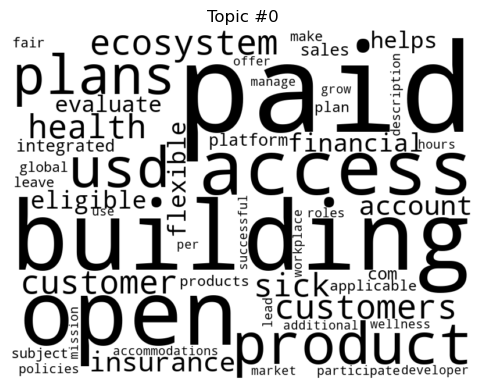

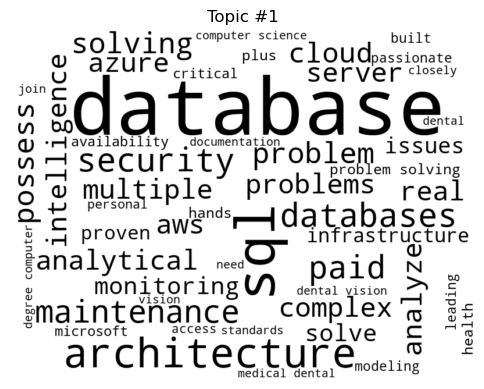

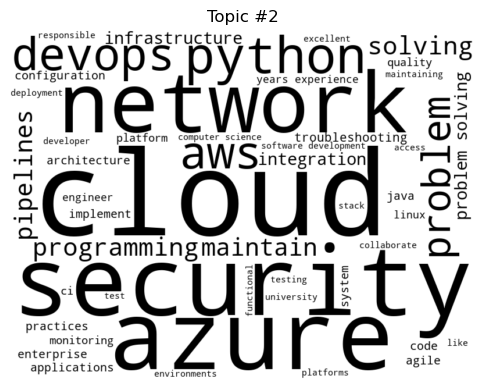

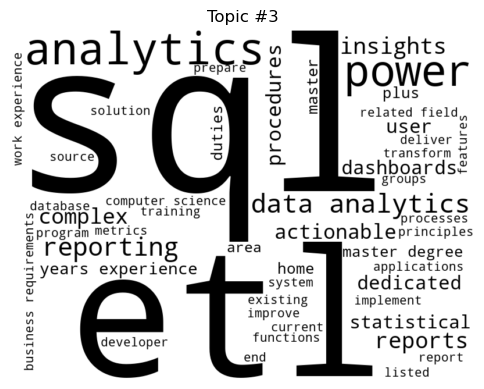

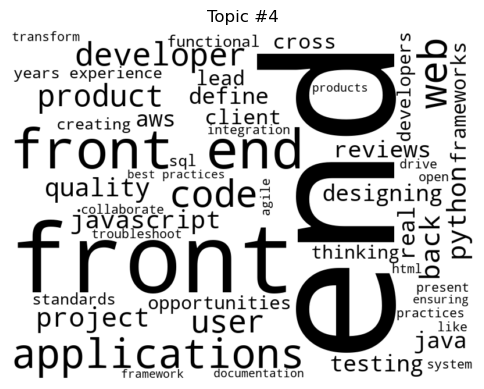

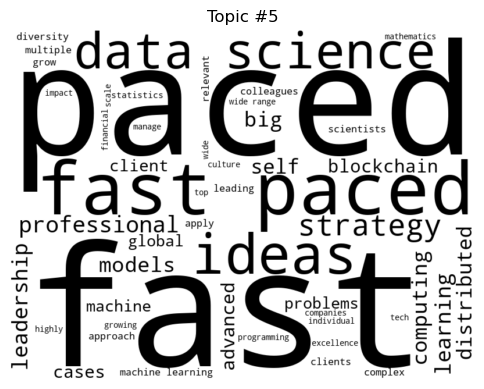

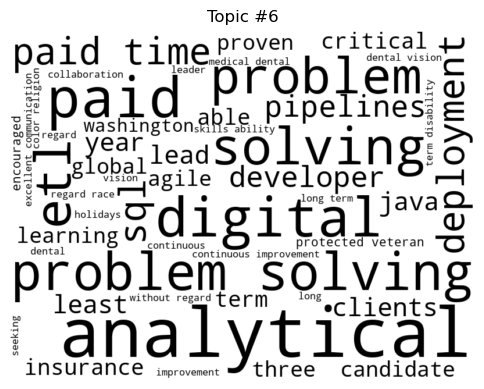

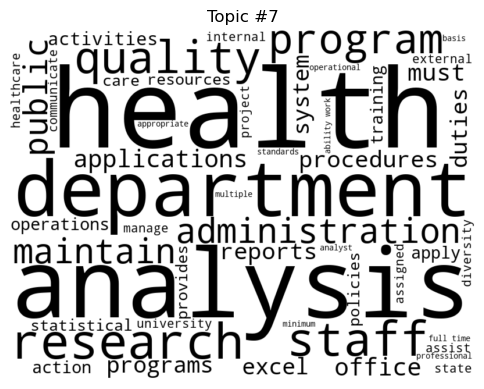

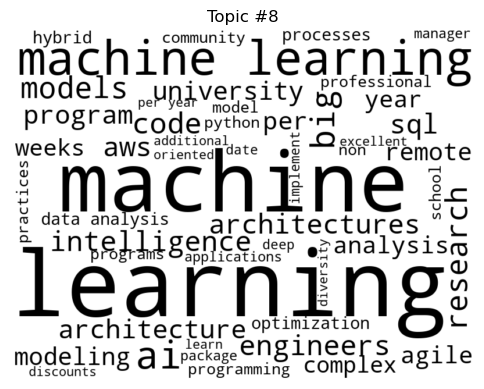

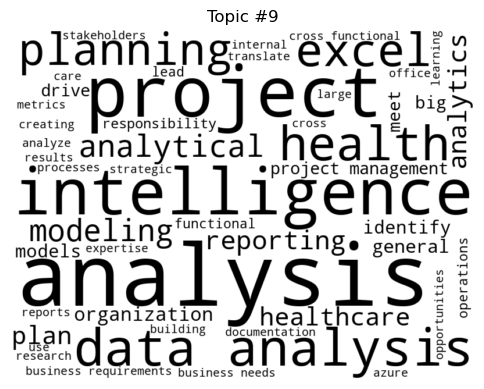

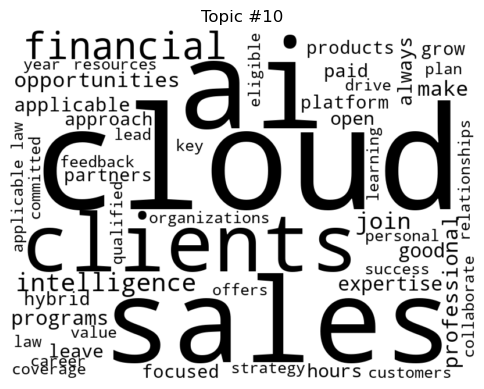

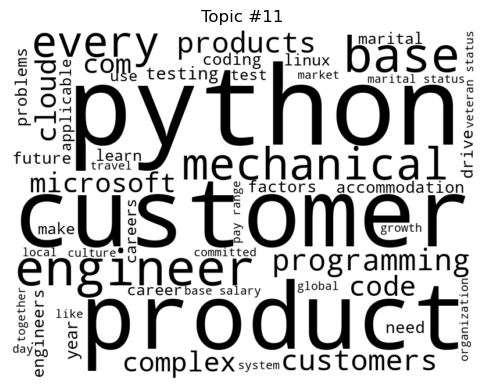

In [38]:
def generate_wordclouds(topics, dictionary):
    for topic_num, topic_words in topics:
        word_freq = dict(topic_words)
        wordcloud = WordCloud(
            width = 800,
            height = 600,
            background_color ='white',
            color_func=lambda *args, **kwargs: "black", # Ensures words are in black
            min_font_size = 10).generate_from_frequencies(word_freq)
        
        plt.figure(figsize = (6, 6), facecolor = None)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Topic #{topic_num}')
        plt.show()

# Generate word clouds for each topic
generate_wordclouds(topics, lda_model.id2word)

In [39]:
# Function to get the most probable topic for a document
def get_most_probable_topic(lda_model, document):
    topics = lda_model.get_document_topics(document, minimum_probability=0.2)
    if topics:
        return max(topics, key=lambda x: x[1])[0]
    else:
        return "Other"

# Apply the function to each document in the corpus
df_jobs['Cluster_job_title'] = [get_most_probable_topic(lda_model, doc) for doc in corpus]

# Map the topic numbers to your specified categories, one of the 12 job titles:
# 'Data Science','Mechanical Engineer','Sales','Java Developer', 'Business Analyst','Operations Manager', 'Python Developer', 'DevOps Engineer',
# 'Network Security Engineer', 'Database','Blockchain','ETL Developer'
# TODO: Check Them !!
topic_mapping = { 
    0: 'Operations Manager',
    1: 'Network Security Engineer',
    2: 'Database',
    3: 'ETL Developer',
    4: 'Java Developer',
    5: 'DevOps Engineer',
    6: 'Blockchain',
    7: 'Business Analyst',
    8: 'Data Science',
    9: 'Python Developer',
    10: 'Sales',
    11: 'Mechanical Engineer'
}

df_jobs['Cluster_job_title'] = df_jobs['Cluster_job_title'].map(topic_mapping)

# Fill NA values with 'Other'
df_jobs['Cluster_job_title'].fillna('Other', inplace=True)

# Display or use df_new with the new 'Cluster_job_title' column
display(df_jobs[['Job_Title_Searched', 'Cluster_job_title']])

,Job_Title_Searched,Cluster_job_title
0,Data Science,Business Analyst
1,Data Science,Data Science
2,Data Science,Data Science
3,Data Science,Business Analyst
4,Data Science,Business Analyst
...,...,...
2155,ETL Developer,Database
2156,ETL Developer,Database
2157,ETL Developer,Mechanical Engineer
2158,ETL Developer,Data Science


### Latent semantic analysis (LSA):

In [40]:
svd = TruncatedSVD(n_components=12)
U = svd.fit_transform(dtm_df)
Sigma = svd.singular_values_
VT = svd.components_


terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('sql', 0.24357313499118816), ('cloud', 0.21507652105146868), ('database', 0.20059930935475612), ('security', 0.15725548924593205), ('python', 0.14685845490755467)]
Topic 2:  [('database', 0.6401715585615853), ('sql', 0.5502233860957465), ('azure', 0.1126372847713333), ('etl', 0.07743282793616822), ('server', 0.07626337695947324)]
Topic 3:  [('cloud', 0.3872838224796448), ('security', 0.32572904367225264), ('azure', 0.32350991031330567), ('network', 0.29819272480609005), ('devops', 0.19937938773833297)]
Topic 4:  [('learning', 0.35361625500264326), ('azure', 0.33770750375243336), ('machine', 0.2924694135921524), ('machine learning', 0.2810123696071077), ('cloud', 0.2676577182499024)]
Topic 5:  [('network', 0.5129568308193723), ('security', 0.38409430204259537), ('learning', 0.2537904889548747), ('machine', 0.23579308049249476), ('machine learning', 0.22279445019981267)]
Topic 6:  [('sales', 0.45200600833895216), ('database', 0.26857449484279783), ('cloud', 0.2505276752578409

### Plotting LDA Topics

In [41]:
vis_data = gensimvis.prepare(lda_model, corpus, dic)
pyLDAvis.display(vis_data)

Comment graph... (Most of them seem to be in a cluster which is not surprising as most are IT related jobs and some Business)

### Coherence of topics

In [42]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-1.2572497793447948

In [43]:
"""def compute_coherence(num_topics, corpus, dictionary):
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    return coherence

coherence_values = []

min_topics = 5
max_topics = 15
step_size = 1

# Iterate over different numbers of topics
for num_topics in range(min_topics, max_topics + 1, step_size):
    coherence = compute_coherence(num_topics, corpus, dictionary)
    coherence_values.append(coherence)
    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# Plotting coherence values vs. number of topics
plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence vs. Number of Topics")
plt.xticks(range(min_topics, max_topics + 1, step_size))
plt.grid(True)
plt.show()"""

'def compute_coherence(num_topics, corpus, dictionary):\n    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)\n    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence=\'u_mass\')\n    coherence = coherence_model.get_coherence()\n    return coherence\n\ncoherence_values = []\n\nmin_topics = 5\nmax_topics = 15\nstep_size = 1\n\n# Iterate over different numbers of topics\nfor num_topics in range(min_topics, max_topics + 1, step_size):\n    coherence = compute_coherence(num_topics, corpus, dictionary)\n    coherence_values.append(coherence)\n    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")\n\n# Plotting coherence values vs. number of topics\nplt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)\nplt.xlabel("Number of Topics")\nplt.ylabel("Coherence Score")\nplt.title("Coherence vs. Number of Topics")\nplt.xticks(range(min_topics, max_topics + 1, step_size))\nplt.gr

# Model comparaison - Job offers
Compare different models... only on the job dataset

### Stem words in corpus

In [44]:
# modulation: 0 -> remove stop words, 1 -> remove stop words and stem words, 2 -> remove stop words and lemmatize words
df_jobs["cleaned_description"] = df_jobs["cleaned_description"].apply(tokenize, modulation=1)
df_jobs["cleaned_text_skills"] = df_jobs["cleaned_text_skills"].apply(tokenize, modulation=1) 

df_extracted["cleaned_extracted_description"] = df_extracted["cleaned_extracted_description"].apply(tokenize, modulation=1)

df_resume["cleaned_resume_skills"] = df_resume["cleaned_resume_skills"].apply(tokenize, modulation=1)
df_resume["cleaned_resume"] = df_resume["cleaned_resume"].apply(tokenize, modulation=1)

metrics = Metrics()

### Model: LDA

In [45]:
# Create document term matrix using CountVectorizer
pd.set_option('display.max_columns', None)
vec = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X = vec.fit_transform(df_jobs['cleaned_text_skills']) # TODO: Compare with other 'corpuses'
vectorized_jobs=X.todense()

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

# Number of topics
num_topics = 12

# Build LDA model
lda_model, corpus, dic = get_lda_topics(dtm_df, num_topics)

# Apply the function to each document in the corpus
df_jobs['pred_LDA'] = [get_most_probable_topic(lda_model, doc) for doc in corpus]

# Map the topic numbers to your specified categories
df_jobs['pred_LDA'] = df_jobs['pred_LDA'].map(topic_mapping)

# Fill NA values with 'Other'
df_jobs['pred_LDA'].fillna('Other', inplace=True)

Metrics:

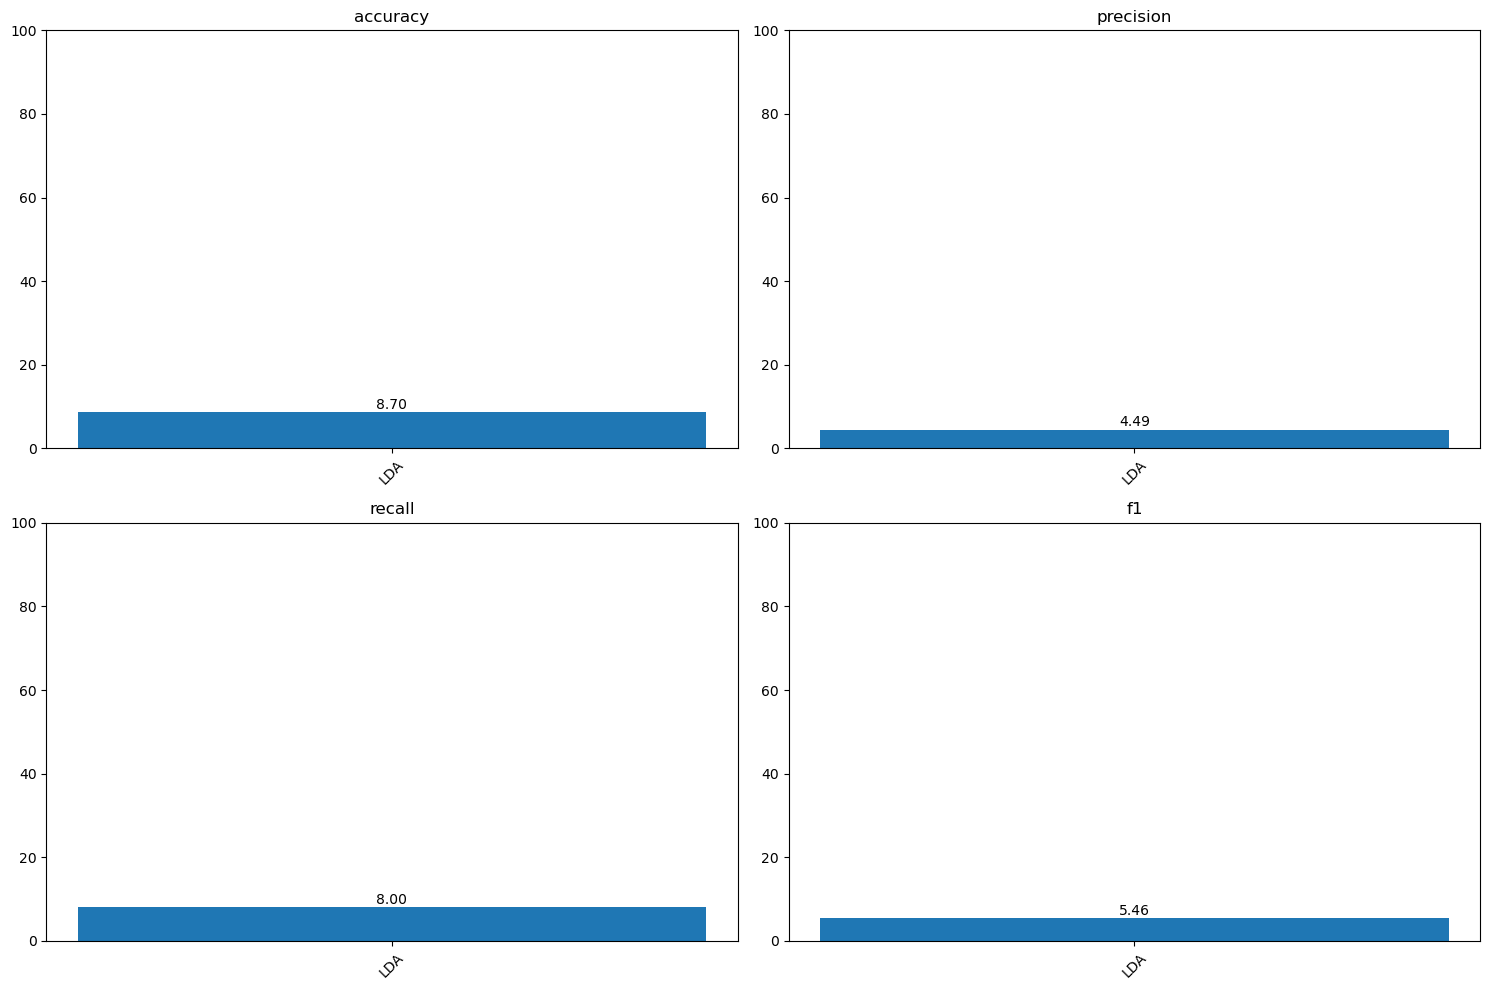

In [46]:
y_true = df_jobs['Job_Title_Searched']
y_pred = df_jobs['pred_LDA']
metrics.run(y_true, y_pred, 'LDA')
metrics.plot()

### Model: Job cluster matching

Matches with every job posting and to store the 10 job cluster that held the highest values for cosine similarity and then take the mode of the one appearing the most as follows.

In [47]:
# Initialize a dictionary to store the top 10 matches for each job offer
matching_dictionary = {}

# Iterate through each job oofer and find the top 10 matches
for j_id, j_vector in enumerate(vectorized_jobs):
    similarities = {}
    top_matches = []
    for job_id, job_vector in enumerate(vectorized_jobs):
        similarity = float(cosine_similarity(j_vector, job_vector))
        # Sort the dictionary based on values in ascending order
        if len(similarities)<10:
            similarities[job_id]=similarity
        elif similarity>next(iter(similarities.values())):
            first_key = next(iter(similarities))
            similarities[job_id] = similarity
            del similarities[first_key]
        similarities = dict(sorted(similarities.items(), key=lambda item: item[1]))
    # top_matches = similarities[-10:][::-1]  # Get indices of top 10 matches
    matching_dictionary[j_id] = similarities

In [48]:
# Create a DataFrame to store the results
columns = [f"Match_{i+1}" for i in range(10)]
result_df = pd.DataFrame(columns=columns)

# Iterate through each job offer in df_new and extract the top 10 job titles
for job_id, matches in matching_dictionary.items():
    job_ids = list(matches.keys())
    job_titles = df_jobs.loc[df_jobs['id'].isin(job_ids), 'Job_Title_Searched'].tolist()
    result_df.loc[job_id] = job_titles

# Concatenate the result_df with df_new
result_df = pd.concat([df_jobs, result_df], axis=1, join='inner')

# Function to find the most common element in a list
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get) # TODO: This line might take Job_Title_Searched/Cluster_job_title as the one value -> check

# Add 'Predicted_job' column based on the most common job title in each row
result_df['pred_cluster'] = result_df.apply(lambda row: most_common(row), axis=1)
# Display or use result_df as needed
result_df=result_df.drop(columns=columns, axis = 1)

# Fill NA values with 'Other'
result_df['pred_cluster'].fillna('Other', inplace=True)

result_df.head()

,Job_Title_Searched,Description,cleaned_description,cleaned_extracted_description,id,hard_skills,soft_skills,cleaned_text_skills,Cluster_job_title,pred_LDA,pred_cluster
0,Data Science,About the California Policy Lab\nThe Californi...,california polici lab california polici lab tr...,NaN,0,time employees coding python r stata task dema...,multiple projects concurrently seek time manag...,california polici lab california polici lab tr...,Business Analyst,Network Security Engineer,Data Science
1,Data Science,Job Description\nThe Research Data Scientist p...,job descript research data scientist particip ...,include querying databases data processing sup...,1,description research data mining machine learn...,,job descript research data scientist particip ...,Data Science,Java Developer,Data Science
2,Data Science,Expatiate Communications is a boutique managem...,expati communic boutiqu manag consult firm unm...,develop implement algorithms variety data sour...,2,algorithms implement state art algorithms shel...,organizational attention detail,expati communic boutiqu manag consult firm unm...,Data Science,Java Developer,Data Science
3,Data Science,EXAM NUMBER:\nPH1763B\n\nTYPE OF RECRUITMENT:\...,exam number ph b type recruit open competit jo...,serving description duties sufficient demonstr...,3,type open competitive analyze structured unstr...,communicate findings technical nontechnical st...,exam number ph b type recruit open competit jo...,Business Analyst,Network Security Engineer,Data Science
4,Data Science,Salary: $42.59 - $57.40 Per Hour\nSUMMARY\nCom...,salari per hour summari communiti program prog...,position may participate tracking reporting qu...,4,statistical programming model selection deploy...,requirements accuracy completeness data resear...,salari per hour summari communiti program prog...,Business Analyst,Network Security Engineer,Data Science


In [49]:
y_true = result_df['Job_Title_Searched']
y_pred = result_df['pred_cluster']
metrics.run(y_true, y_pred, 'Cluster')

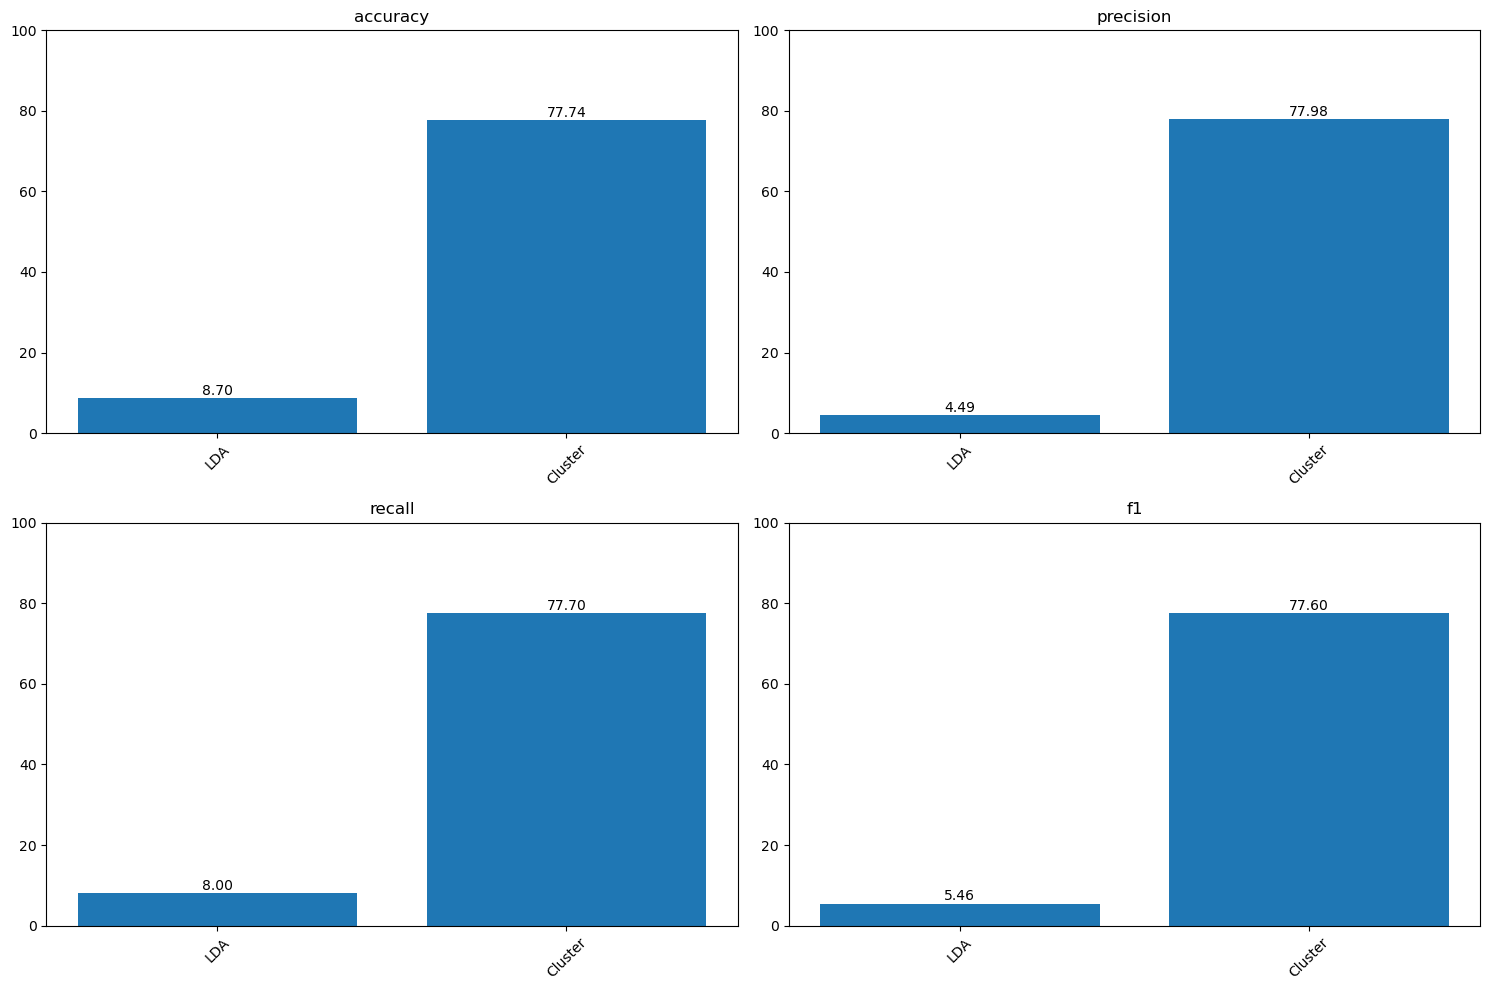

In [50]:
metrics.plot()

### Model: Cosine similarity matching

This second machin model approach computes the average cosine similarity between each job cluster and the resume and then picking the cluster which held the highest cosine similarity as follows. 

In [51]:
# Initialize dictionaries to store the similarity scores and average similarity for each job offer and cluster
similarity_scores_dictionary = {}
average_similarity_dictionary = {}

# Iterate through each job offer and find the similarity scores for each cluster
for j_id, j_vector in enumerate(vectorized_jobs):
    cluster_similarities = {cluster: [] for cluster in df_jobs['Job_Title_Searched'].unique()}
    
    for job_id, job_vector in enumerate(vectorized_jobs):
        similarity = float(cosine_similarity(j_vector, job_vector))
        cluster = df_jobs.loc[df_jobs['id'] == job_id, 'Job_Title_Searched'].iloc[0]
        cluster_similarities[cluster].append(similarity)
    
    # Store the similarity scores in the dictionary
    similarity_scores_dictionary[j_id] = cluster_similarities

    # Compute the average similarity for each cluster
    average_similarity = {f"{cluster}": np.mean(similarities) for cluster, similarities in cluster_similarities.items()}
    
    # Store the results in the dictionary
    average_similarity_dictionary[j_id] = average_similarity
# Create DataFrames for average similarity and similarity scores
average_similarity_df = pd.DataFrame(average_similarity_dictionary).T

# Add columns to the existing DataFrame
df_result = pd.concat([df_jobs, average_similarity_df], axis=1, join='inner')

# Add a column for the predicted cluster based on the highest average similarity
df_result['pred_group'] = df_result.loc[:, average_similarity_df.columns].idxmax(axis=1)

# Fill NA values with 'Other'
df_result['pred_group'].fillna('Other', inplace=True)

# Display or use df_result as needed
df_result.head()

,Job_Title_Searched,Description,cleaned_description,cleaned_extracted_description,id,hard_skills,soft_skills,cleaned_text_skills,Cluster_job_title,pred_LDA,Data Science,Mechanical Engineer,Sales,Java Developer,Business Analyst,Operations Manager,Python Developer,DevOps Engineer,Network Security Engineer,Database,Blockchain,ETL Developer,pred_group
0,Data Science,About the California Policy Lab\nThe Californi...,california polici lab california polici lab tr...,NaN,0,time employees coding python r stata task dema...,multiple projects concurrently seek time manag...,california polici lab california polici lab tr...,Business Analyst,Network Security Engineer,0.273166,0.133895,0.092015,0.142369,0.183325,0.108761,0.183651,0.122163,0.103000,0.221597,0.153222,0.168574,Data Science
1,Data Science,Job Description\nThe Research Data Scientist p...,job descript research data scientist particip ...,include querying databases data processing sup...,1,description research data mining machine learn...,,job descript research data scientist particip ...,Data Science,Java Developer,0.363363,0.112311,0.036777,0.112213,0.117543,0.047694,0.173967,0.128681,0.072119,0.210643,0.114486,0.175665,Data Science
2,Data Science,Expatiate Communications is a boutique managem...,expati communic boutiqu manag consult firm unm...,develop implement algorithms variety data sour...,2,algorithms implement state art algorithms shel...,organizational attention detail,expati communic boutiqu manag consult firm unm...,Data Science,Java Developer,0.260370,0.100420,0.062370,0.095961,0.137022,0.073773,0.138081,0.089917,0.105792,0.122050,0.153639,0.114179,Data Science
3,Data Science,EXAM NUMBER:\nPH1763B\n\nTYPE OF RECRUITMENT:\...,exam number ph b type recruit open competit jo...,serving description duties sufficient demonstr...,3,type open competitive analyze structured unstr...,communicate findings technical nontechnical st...,exam number ph b type recruit open competit jo...,Business Analyst,Network Security Engineer,0.301718,0.218910,0.165435,0.172303,0.245347,0.195479,0.164964,0.152373,0.196936,0.196697,0.212455,0.180946,Data Science
4,Data Science,Salary: $42.59 - $57.40 Per Hour\nSUMMARY\nCom...,salari per hour summari communiti program prog...,position may participate tracking reporting qu...,4,statistical programming model selection deploy...,requirements accuracy completeness data resear...,salari per hour summari communiti program prog...,Business Analyst,Network Security Engineer,0.357938,0.140473,0.079668,0.115745,0.206006,0.110213,0.130958,0.101663,0.092136,0.234801,0.131233,0.229612,Data Science


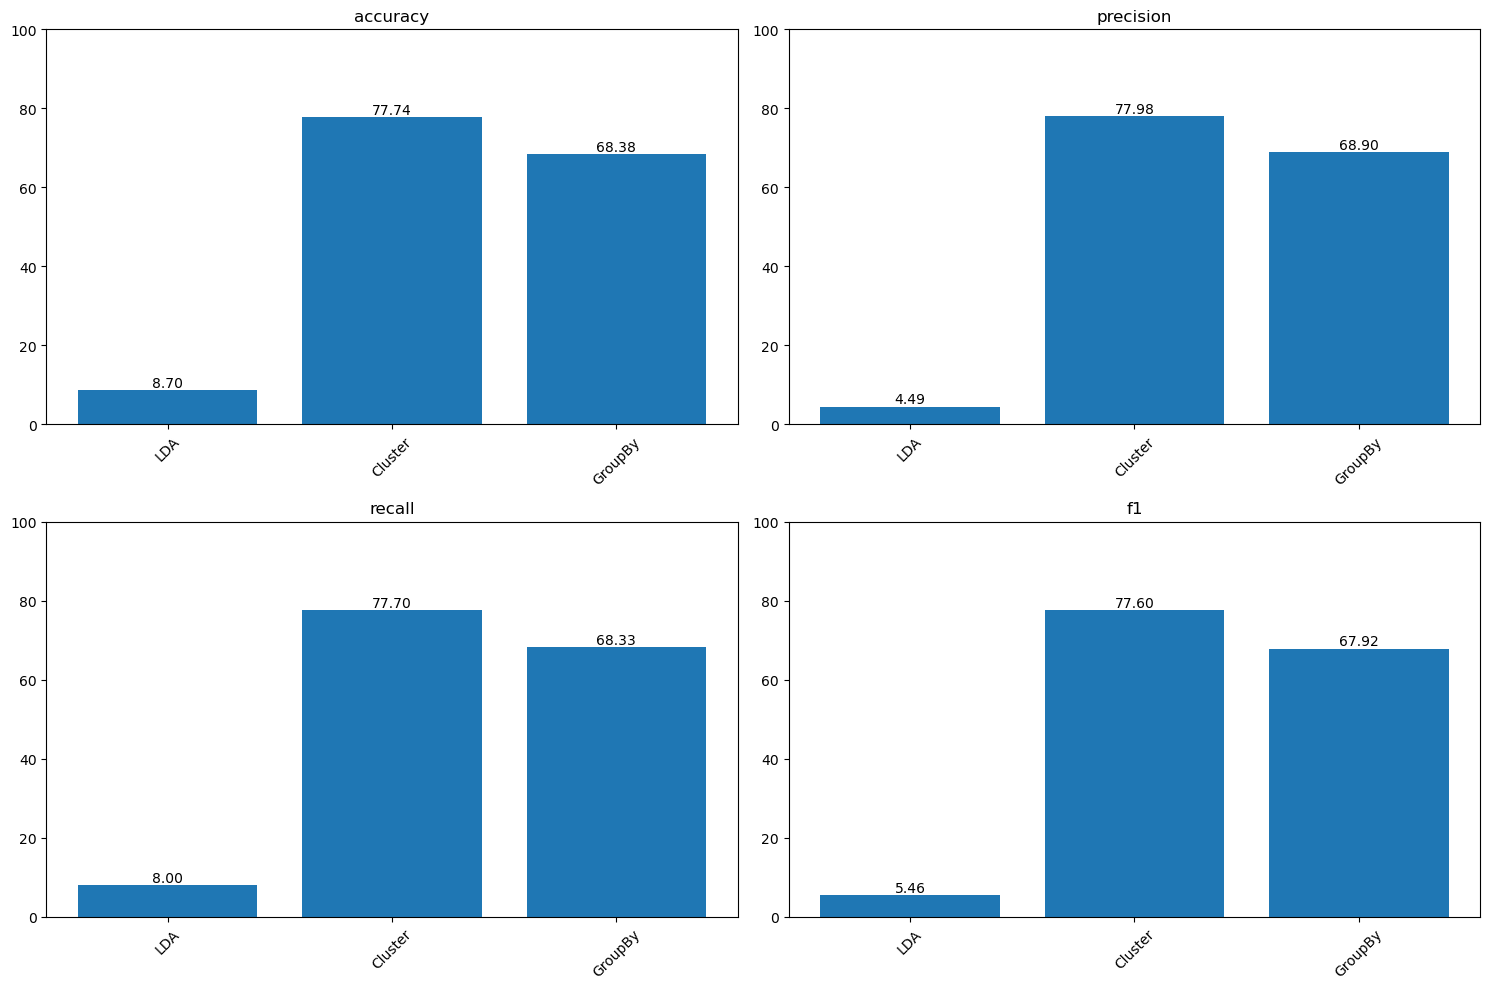

In [52]:
y_true = df_result["Job_Title_Searched"]
y_pred = df_result["pred_group"]
metrics.run(y_true, y_pred, 'GroupBy')
metrics.plot()

### Model: Logistic Regression

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_jobs['cleaned_text_skills'], df_jobs['Job_Title_Searched'], test_size=0.2, random_state=42)

Best Parameters: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.8, 'tfidf__min_df': 0.03, 'tfidf__ngram_range': (1, 2)}


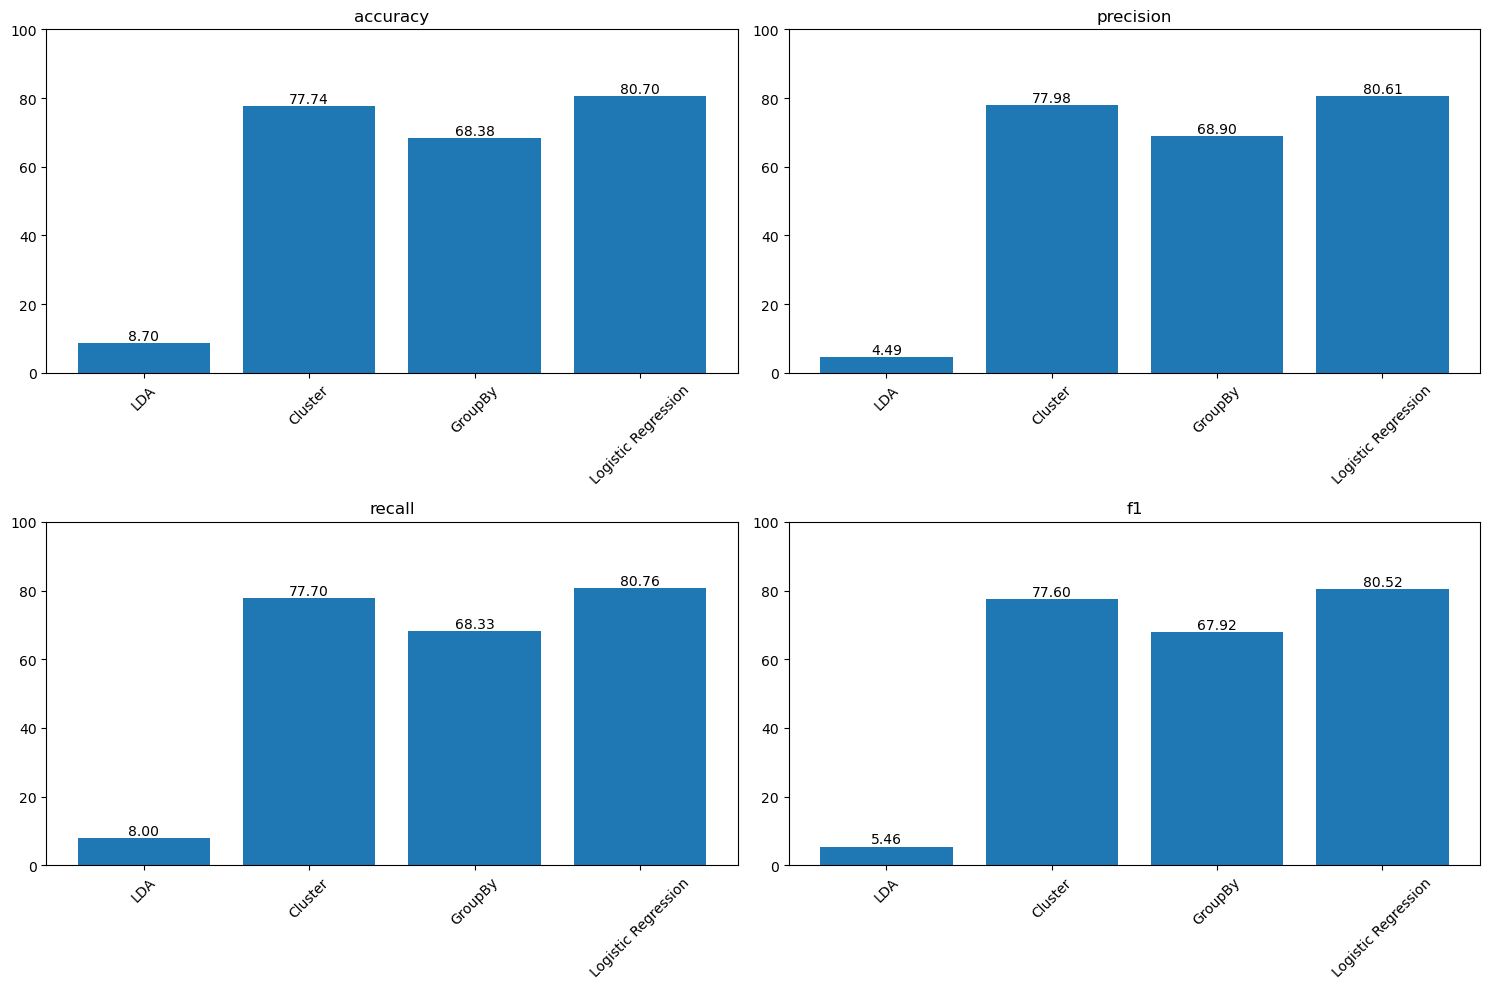

In [54]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear')),
])

param_grid_tested = {
    'tfidf__min_df': [0.05, 0.1, 0.15, 0.2],
    'tfidf__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],  
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2)],

    'clf__C': [0.1,0.5, 1,2],
    'clf__penalty': ['l2','l1','elasticnet'],
}

# Best parameters found by grid search
param_grid = {
    'tfidf__min_df': [0.01,0.02,0.03],
    'tfidf__max_df': [0.85,0.8,0.9],  
    'tfidf__ngram_range': [ (1, 2)],

    'clf__C': [2],
    'clf__penalty': ['l2'],
}

# Create a GridSearchCV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

metrics.run(y_test, y_pred, 'Logistic Regression')

# Best parameters found by grid search
print(f'Best Parameters: {grid_search.best_params_}')
metrics.plot()

### Model: Random Forest Classifier

Best Parameters: {'rfc__max_depth': None, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}


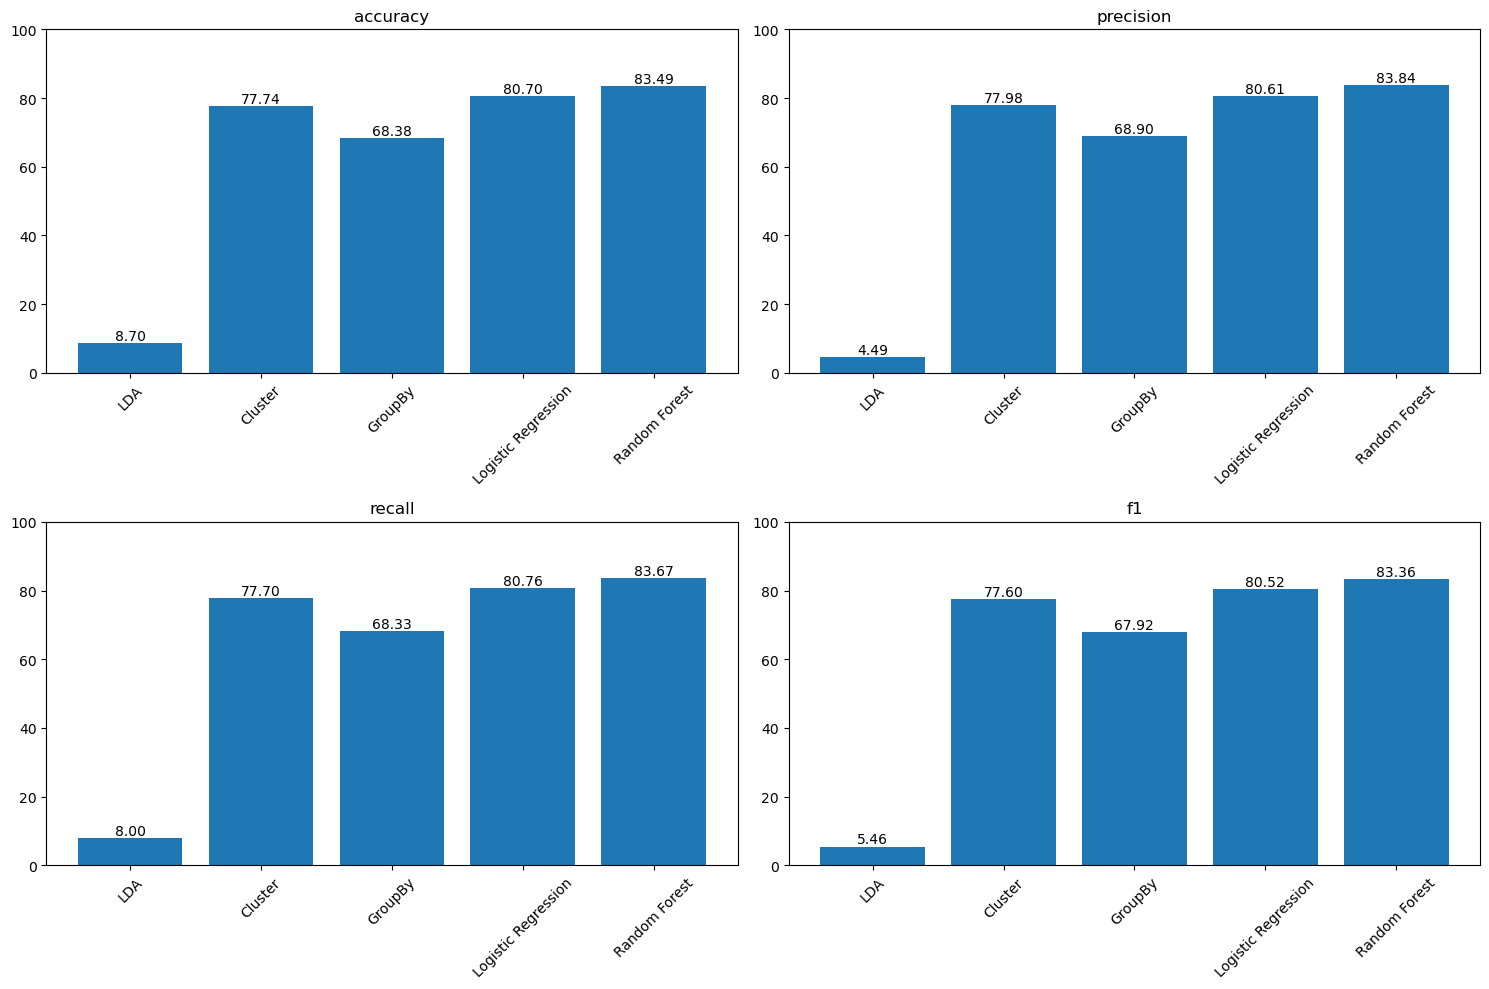

In [55]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

param_grid_tested = {
    'tfidf__min_df': [0.05, 0.1, 0.15, 0.2],
    'tfidf__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],  
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2)],

    'rfc__n_estimators': [10,20,50,100,200],
    'rfc__max_depth': [10,20,None],
    'rfc__min_samples_split': [2,5,10],
}

# Best parameters found by grid search
param_grid = {
    'tfidf__min_df': [0.05],
    'tfidf__max_df': [0.5, 0.7],  
    'tfidf__ngram_range': [ (1, 3)],

    'rfc__n_estimators': [100],
    'rfc__max_depth': [20, None],
    'rfc__min_samples_split': [5],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

metrics.run(y_test, y_pred, 'Random Forest')

# Best parameters found by grid search
print(f'Best Parameters: {grid_search.best_params_}')
metrics.plot()

# Model comparaison - Resume/CV
Compare different models... only on the cv/resume dataset
### Document Term Matrix
Fitting a new count vectorizer using job postings. Job postings were used as those will be the reference for all the required skills. Unnecessary information (tokens) in the resumes that are not mentioned in any of the job postings will not appear in the matrix.

In [56]:
# Create document term matrix using CountVectorizer
pd.set_option('display.max_columns', None)
cv_final = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
cv_final.fit(df_jobs['cleaned_text_skills']) # TODO: Try with other 'corpuses'

X_jobs = cv_final.transform(df_jobs['cleaned_text_skills'])
vectorized_jobs=X_jobs.todense()
print("JOB- Document term matrix has size:", vectorized_jobs.shape)
X_resumes = cv_final.transform(df_resume['cleaned_resume_skills'])
vectorized_resumes=X_resumes.todense()
print("CV - Document term matrix has size:", vectorized_resumes.shape)

JOB- Document term matrix has size: (2149, 912)
CV - Document term matrix has size: (513, 912)


In [57]:
term_frequencies = np.sum(vectorized_jobs, axis=0).A1

# Sort frequencies and get sorted indices
sorted_indices = np.argsort(term_frequencies)[::-1]
sorted_frequencies = term_frequencies[list(sorted_indices)]

# Generate Term IDs (1-based indexing for better readability)
term_ids = np.arange(1, len(sorted_frequencies) + 1)

# Find the maximum value in the sorted frequencies
max_term_frequency = np.max(sorted_frequencies)
print("Max term frequency is", max_term_frequency)

# Get the feature names from the count vectorizer
feature_names = cv_final.get_feature_names_out()

# Now use sorted_indices to get the top terms
top_indices = sorted_indices[:5]  # Get the indices for the top 5 terms
top_terms = feature_names[top_indices]  # Get the corresponding feature names

# Now print out the top terms with their frequencies
for term, freq in zip(top_terms, sorted_frequencies[:5]):
    print(f"Term: {term}, Frequency: {freq}")

Max term frequency is 4537
Term: sql, Frequency: 4537
Term: databas, Frequency: 4465
Term: cloud, Frequency: 3988
Term: secur, Frequency: 3645
Term: python, Frequency: 3568


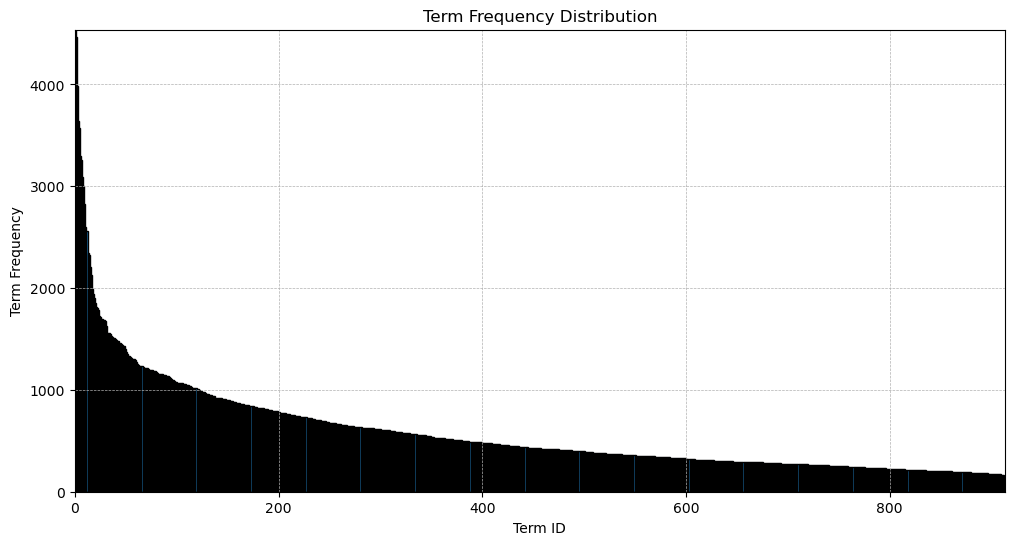

In [58]:
# Plotting with adjusted y-axis limits
plt.figure(figsize=(12, 6))
plt.bar(term_ids, sorted_frequencies, width=1.0, edgecolor='black')

# Set the y-axis and x-axis limits to start at 0 and end at the maximum
plt.ylim(0, max_term_frequency)
plt.xlim(left=0, right=len(term_ids)+1) 

# Improve the appearance
plt.title('Term Frequency Distribution')
plt.xlabel('Term ID')
plt.ylabel('Term Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.axhline(y=0, color='black', linewidth=1)

plt.show()

### Model: LDA

In [59]:
# Not possible?

### Model: Job cluster matching

In [60]:
# Initialize a dictionary to store the top 10 matches for each resume
matching_dictionary = {}

# Iterate through each job oofer and find the top 10 matches
for resume_id, resume_vector in enumerate(vectorized_resumes):
    similarities = {}
    top_matches = []
    for job_id, job_vector in enumerate(vectorized_jobs):
        similarity = float(cosine_similarity(resume_vector, job_vector))
        # Sort the dictionary based on values in ascending order
        if len(similarities)<10:
            similarities[job_id]=similarity
        elif similarity>next(iter(similarities.values())):
            first_key = next(iter(similarities))
            similarities[job_id] = similarity
            del similarities[first_key]
        similarities = dict(sorted(similarities.items(), key=lambda item: item[1]))
    # top_matches = similarities[-10:][::-1]  # Get indices of top 10 matches
    matching_dictionary[resume_id] = similarities

In [61]:
# Create a DataFrame to store the results
columns = [f"Match_{i+1}" for i in range(10)]
result_df = pd.DataFrame(columns=columns)

# Iterate through each resume in df_new and extract the top 10 job titles
for resume_id, matches in matching_dictionary.items():
    job_ids = list(matches.keys())
    job_titles = df_jobs.loc[df_jobs['id'].isin(job_ids), 'Job_Title_Searched'].tolist()
    result_df.loc[resume_id] = job_titles

# Concatenate the result_df with df_new
result_df = pd.concat([df_resume, result_df], axis=1, join='inner')

# Function to find the most common element in a list
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

# Add 'Predicted_job' column based on the most common job title in each row
result_df['pred_cluster_cv'] = result_df.apply(lambda row: most_common(row), axis=1)
# Display or use result_df as needed
result_df=result_df.drop(columns=columns, axis = 1)

# Fill NA values with 'Other'
result_df['pred_cluster_cv'].fillna('Other', inplace=True)

result_df.head()

,index,Category,Resume,cleaned_resume,Experience,Skills,Education,id,hard_skills,soft_skills,cleaned_resume_skills,pred_cluster_cv
0,0,Data Science,Skills * Programming Languages: Python (pandas...,skill program languag python panda numpi scipi...,javascript exprience months jquery exprience ...,skills programming languages python pandas num...,data science assurance associate data science...,0,programming python sql java jquery machine lea...,pandas numpy multiple data science analytic pr...,skill program languag python panda numpi scipi...,Data Science
1,1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,educ detail may may b e uit rgpv data scientis...,python exprience less year months statsmodels...,NaN,may may b e uit rgpv data scientist data scie...,1,machine learning india developed auto preproce...,,educ detail may may b e uit rgpv data scientis...,Data Science
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learn control system design...,data analysis exprience less year months exce...,areas interest deep learning control system de...,january b tech electrical electronics enginee...,2,design programming python programming matlab p...,,area interest deep learn control system design...,Python Developer
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,linear programming exprience months retail ex...,skills r python sap hana tableau sap hana sql ...,january january pgdm business analytics great...,3,r python tableau sql sql linear programming da...,communication,skill r python sap hana tableau sap hana sql s...,ETL Developer
4,4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",educ detail mca ymcaust faridabad haryana data...,data structure exprience less year months c e...,NaN,mca ymcaust faridabad haryana data science in...,4,,,educ detail mca ymcaust faridabad haryana data...,Data Science


Metrics:

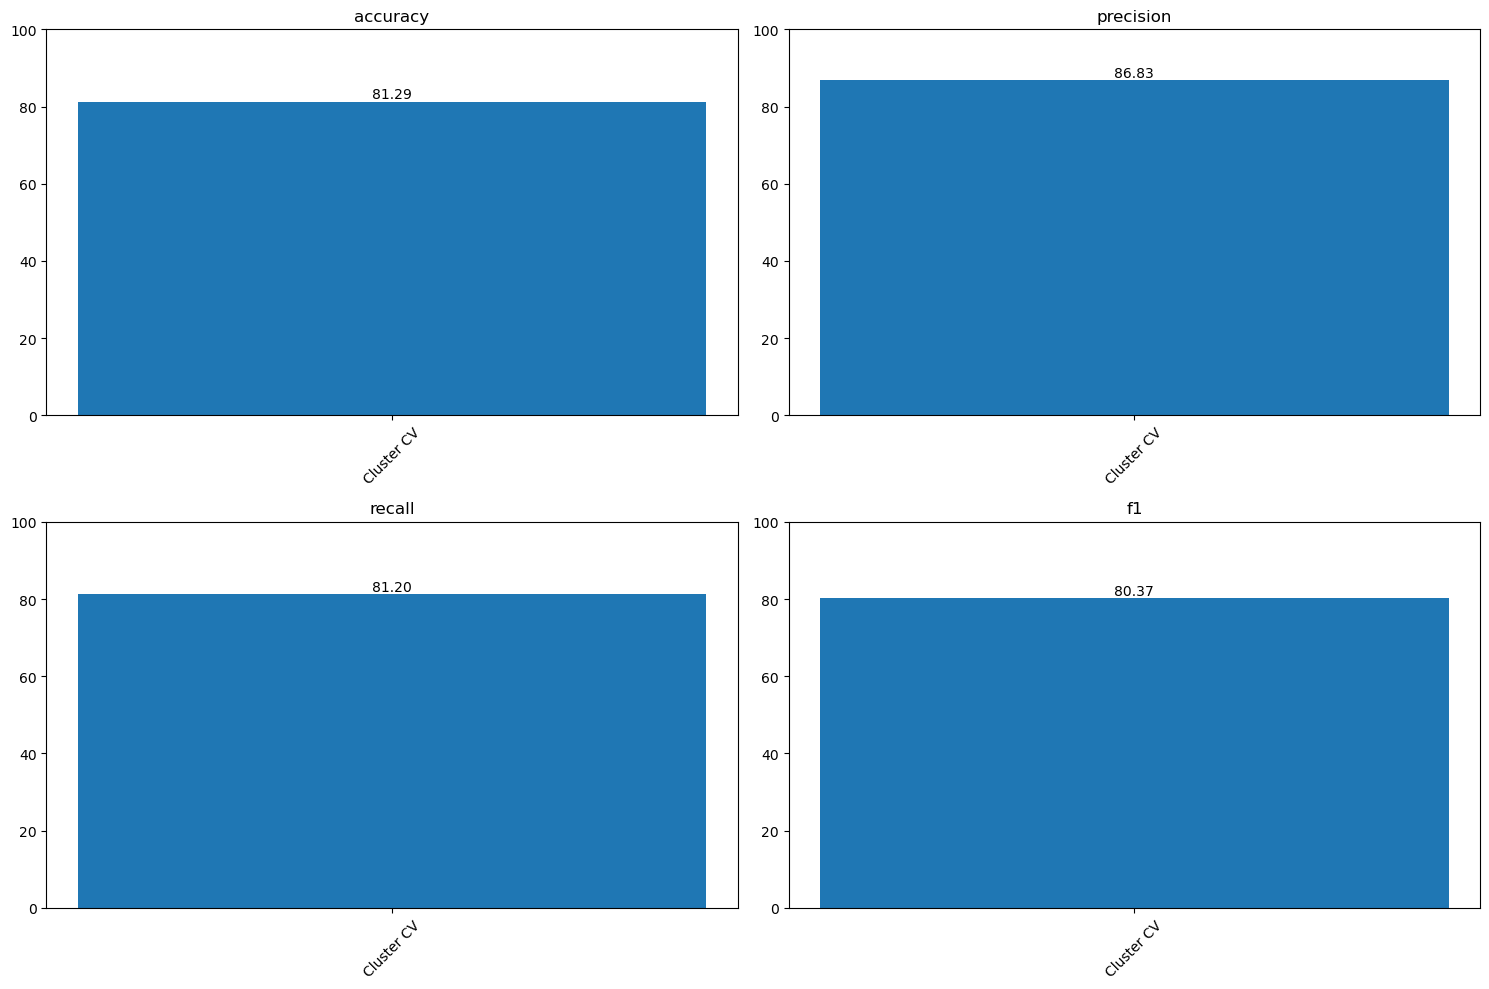

In [62]:
metrics_2 = Metrics()
y_true = result_df['Category']
y_pred = result_df['pred_cluster_cv']
metrics_2.run(y_true, y_pred, 'Cluster CV')
metrics_2.plot()

### Model: Cosine matching

In [63]:
# Initialize dictionaries to store the similarity scores and average similarity for each resume and cluster
similarity_scores_dictionary = {}
average_similarity_dictionary = {}

# Iterate through each resume and find the similarity scores for each cluster
for resume_id, resume_vector in enumerate(vectorized_resumes):
    cluster_similarities = {cluster: [] for cluster in df_jobs['Job_Title_Searched'].unique()}
    
    for job_id, job_vector in enumerate(vectorized_jobs):
        similarity = float(cosine_similarity(resume_vector, job_vector))
        cluster = df_jobs.loc[df_jobs['id'] == job_id, 'Job_Title_Searched'].iloc[0]
        cluster_similarities[cluster].append(similarity)
    
    # Store the similarity scores in the dictionary
    similarity_scores_dictionary[resume_id] = cluster_similarities

    # Compute the average similarity for each cluster
    average_similarity = {f"{cluster}": np.mean(similarities) for cluster, similarities in cluster_similarities.items()}
    
    # Store the results in the dictionary
    average_similarity_dictionary[resume_id] = average_similarity
# Create DataFrames for average similarity and similarity scores
average_similarity_df = pd.DataFrame(average_similarity_dictionary).T

# Add columns to the existing DataFrame
df_result = pd.concat([df_resume, average_similarity_df], axis=1)

# Add a column for the predicted cluster based on the highest average similarity
df_result['pred_cosine_cv'] = df_result.loc[:, average_similarity_df.columns].idxmax(axis=1)

# Display or use df_result as needed
df_result.head()

,index,Category,Resume,cleaned_resume,Experience,Skills,Education,id,hard_skills,soft_skills,cleaned_resume_skills,Data Science,Mechanical Engineer,Sales,Java Developer,Business Analyst,Operations Manager,Python Developer,DevOps Engineer,Network Security Engineer,Database,Blockchain,ETL Developer,pred_cosine_cv
0,0,Data Science,Skills * Programming Languages: Python (pandas...,skill program languag python panda numpi scipi...,javascript exprience months jquery exprience ...,skills programming languages python pandas num...,data science assurance associate data science...,0,programming python sql java jquery machine lea...,pandas numpy multiple data science analytic pr...,skill program languag python panda numpi scipi...,0.277636,0.142498,0.064218,0.147238,0.203718,0.075276,0.223480,0.154033,0.090168,0.190140,0.134445,0.213430,Data Science
1,1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,educ detail may may b e uit rgpv data scientis...,python exprience less year months statsmodels...,NaN,may may b e uit rgpv data scientist data scie...,1,machine learning india developed auto preproce...,,educ detail may may b e uit rgpv data scientis...,0.200225,0.056179,0.037821,0.054181,0.042554,0.028468,0.087168,0.080090,0.038950,0.048837,0.080288,0.055130,Data Science
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learn control system design...,data analysis exprience less year months exce...,areas interest deep learning control system de...,january b tech electrical electronics enginee...,2,design programming python programming matlab p...,,area interest deep learn control system design...,0.187215,0.059719,0.032055,0.110039,0.063922,0.027591,0.291872,0.136536,0.061235,0.069451,0.083778,0.091133,Python Developer
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,linear programming exprience months retail ex...,skills r python sap hana tableau sap hana sql ...,january january pgdm business analytics great...,3,r python tableau sql sql linear programming da...,communication,skill r python sap hana tableau sap hana sql s...,0.248130,0.087602,0.069686,0.138726,0.162452,0.066771,0.181773,0.106838,0.068969,0.282165,0.116828,0.331005,ETL Developer
4,4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",educ detail mca ymcaust faridabad haryana data...,data structure exprience less year months c e...,NaN,mca ymcaust faridabad haryana data science in...,4,,,educ detail mca ymcaust faridabad haryana data...,0.074526,0.051614,0.038414,0.060519,0.066874,0.025868,0.094741,0.039520,0.027005,0.094732,0.054212,0.055906,Python Developer


Metrics:

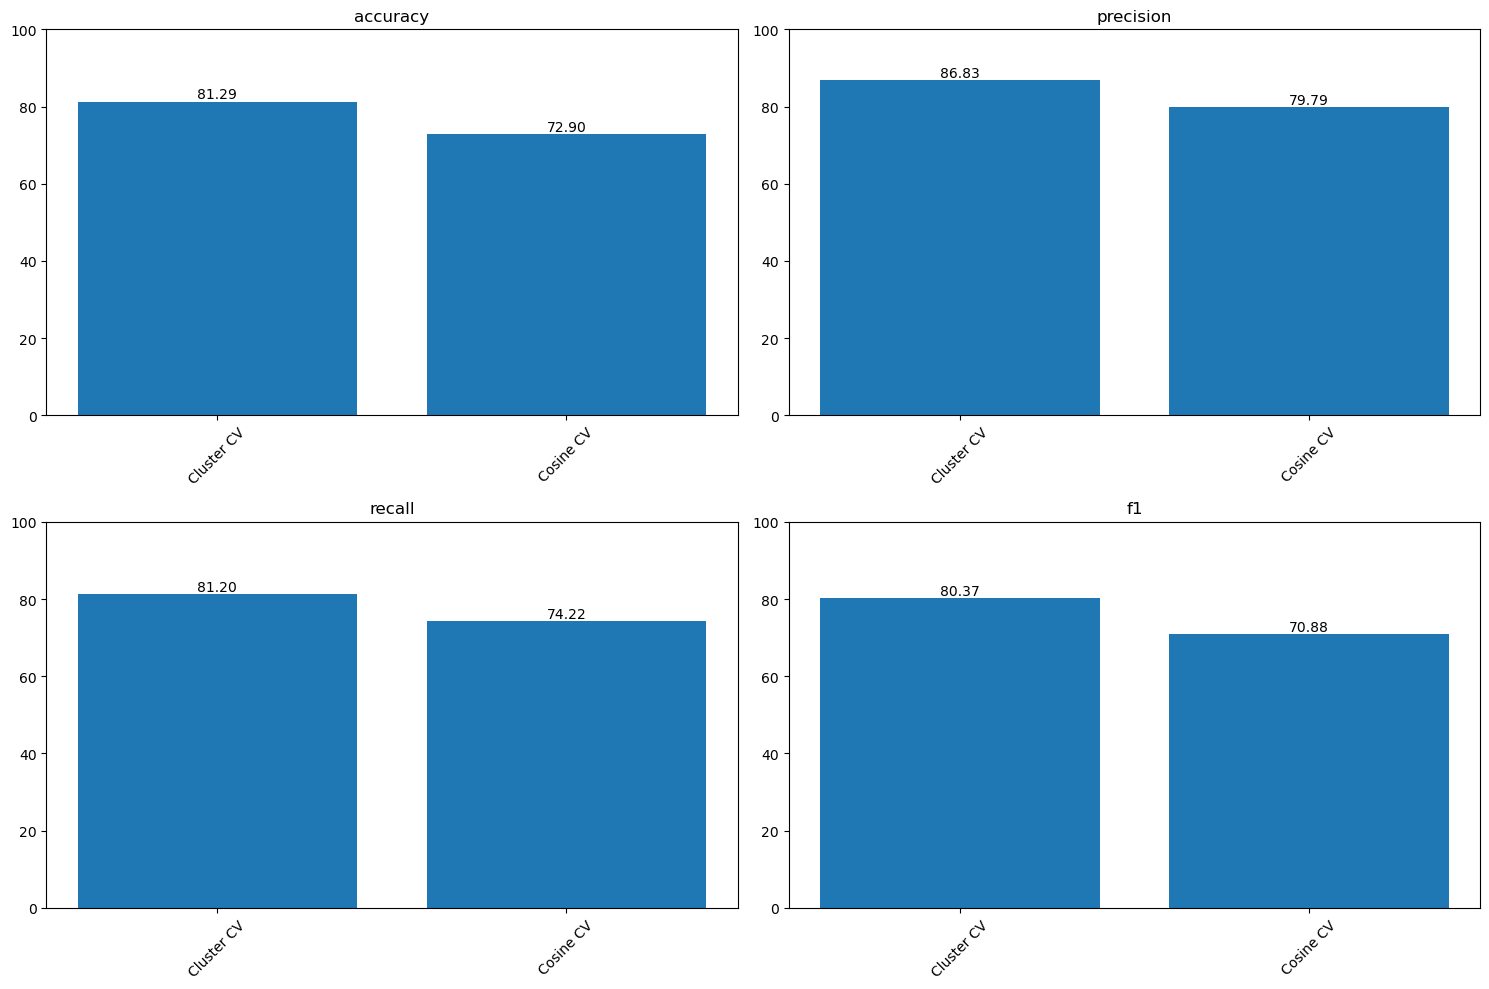

In [64]:
y_true = df_result["Category"]
y_pred = df_result["pred_cosine_cv"]
metrics_2.run(y_true, y_pred, 'Cosine CV')
metrics_2.plot()

### Model: Logistic Regression

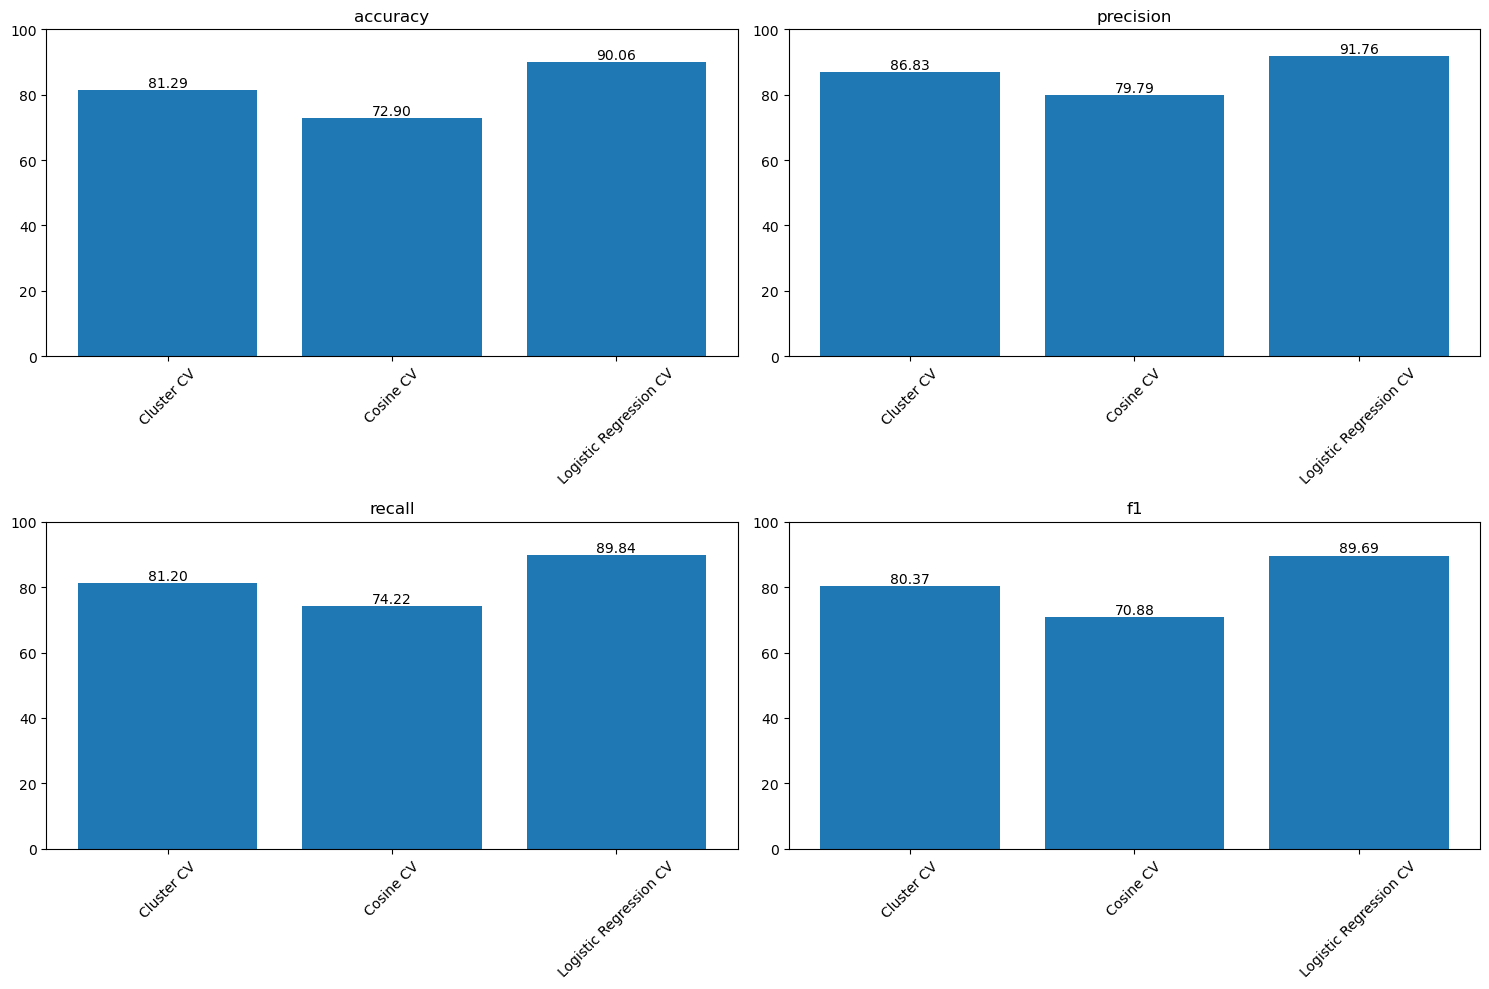

In [65]:
param_grid = {
    'tfidf__min_df': [0.05],
    'tfidf__max_df': [0.5, 0.7],  
    'tfidf__ngram_range': [ (1, 2)],

    'clf__C': [2],
    'clf__penalty': ['l2'],
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Create a GridSearchCV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(df_jobs['cleaned_text_skills'], df_jobs['Job_Title_Searched'])

y_pred = grid_search.predict(df_resume['cleaned_resume_skills'])

metrics_2.run(df_resume['Category'], y_pred, 'Logistic Regression CV')
metrics_2.plot()

### Model: Random Forest Classifier

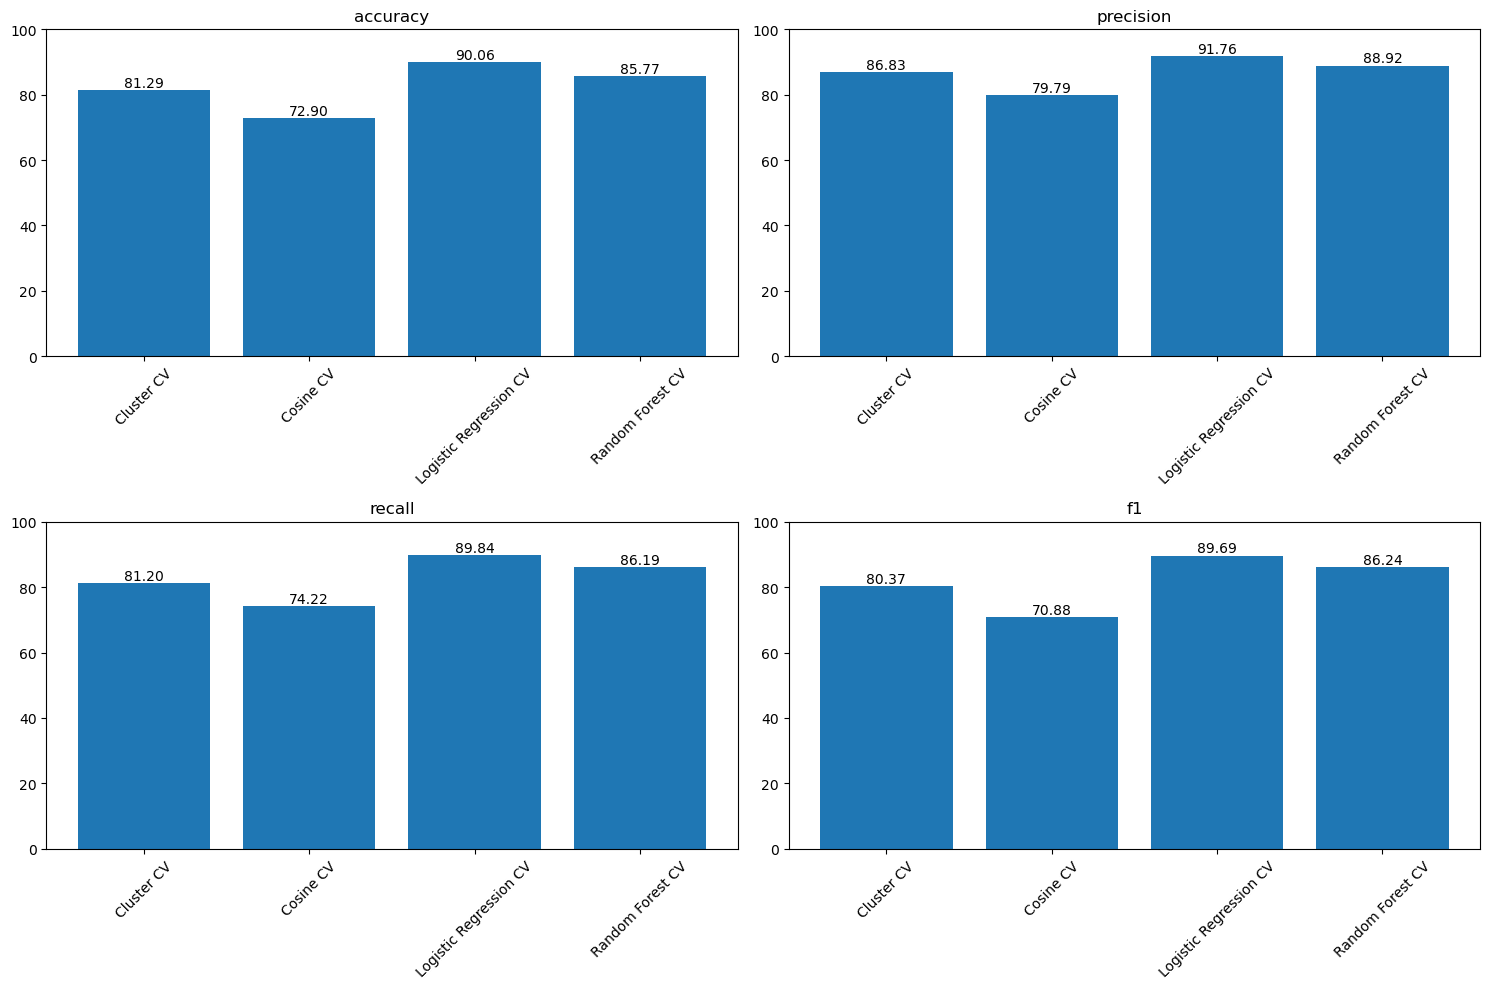

In [66]:
param_grid = {
    'tfidf__min_df': [0.05],  
    'tfidf__max_df': [0.5, 0.7],
    'tfidf__ngram_range': [(1, 2)],

    'rfc__n_estimators': [100],
    'rfc__max_depth': [20, None],
    'rfc__min_samples_split': [5],
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(df_jobs['cleaned_text_skills'], df_jobs['Job_Title_Searched'])

y_pred = grid_search.predict(df_resume['cleaned_resume_skills'])

metrics_2.run(df_resume['Category'], y_pred, 'Random Forest CV')
metrics_2.plot()


## Required Skills per job

In [67]:
df_jobs['Cluster_job_title'].unique()

array(['Business Analyst', 'Data Science', 'Python Developer',
       'Mechanical Engineer', 'Database', 'Operations Manager', 'Sales',
       'Java Developer', 'Blockchain', 'Other',
       'Network Security Engineer', 'ETL Developer', 'DevOps Engineer'],
      dtype=object)

In [68]:
df_new = df_jobs[~df_jobs['Cluster_job_title'].isna()]

In [70]:
# Initialize dictionaries to store the top 10 hard and soft skills for each cluster
top_hard_skills_dict = {}
top_soft_skills_dict = {}

# Iterate through each cluster
for cluster in df_new['Cluster_job_title'].unique():
    # Filter data for the current cluster
    cluster_data = df_new[df_new['Cluster_job_title'] == cluster]
    # display(cluster_data)
    # Create a TF-IDF vectorizer for hard skills
    vectorizer_hard = TfidfVectorizer(stop_words='english', min_df=0.07)
    tfidf_matrix_hard = vectorizer_hard.fit_transform(cluster_data['hard_skills'])
    feature_names_hard = np.array(vectorizer_hard.get_feature_names_out())
    total_tfidf_scores_hard = np.sum(tfidf_matrix_hard, axis=0)
    top_indices_hard = total_tfidf_scores_hard.argsort()[0, -20:][::-1]
    top_hard_skills = feature_names_hard[top_indices_hard]
    top_hard_skills_dict[cluster] = top_hard_skills

    # Create a TF-IDF vectorizer for soft skills
    vectorizer_soft = TfidfVectorizer(stop_words='english', min_df=0.05)
    tfidf_matrix_soft = vectorizer_soft.fit_transform(cluster_data['soft_skills'])
    feature_names_soft = np.array(vectorizer_soft.get_feature_names_out())
    total_tfidf_scores_soft = np.sum(tfidf_matrix_soft, axis=0)
    top_indices_soft = total_tfidf_scores_soft.argsort()[0, -20:][::-1]
    top_soft_skills = feature_names_soft[top_indices_soft]
    top_soft_skills_dict[cluster] = top_soft_skills

# Create new columns 'job_hard_skills' and 'job_soft_skills' in df_new
df_result['job_hard_skills'] = df_result['pred_cluster'].map(top_hard_skills_dict)
df_result['job_soft_skills'] = df_result['pred_cluster'].map(top_soft_skills_dict)

# Display df_new with the new columns
display(df_result[['Predicted_job_cluster', 'job_hard_skills', 'job_soft_skills']])


KeyError: 'pred_cluster'

# TODO:

- Stuff written in notebook

JOB POSTINGS:
- add other datasets for jobs
- more eda, analyze the data
- find the right amount of topics and the correct name for each topic
- Check again the matcher for job descriptions to isolate the information relevant to the job -> this should improve the LDA (did a little bit adding some words to matcher and adding the skills to the text)
- Find a good way to test the results (NOW THEY ARE NOT ACCURATE) -> (Seb:) Only way I found was to reduce the job titles in the Job Offers to the same name/categories as the job titles in the CV dataset, this can then give an approximate score metrics (not perfect labeling)


RESUMES:
- improve the parsing and preprocessing of the curriculums (https://www.kaggle.com/code/valivar/resume-parsing-with-nlp-ml-feb-hotel)
- add other datasets
- eda



# Additional Resources

### Resume parser

In [156]:
nlp = spacy.load('en_core_web_sm')


#Extracting text from DOCX
def extract_text_from_docx(docx_path):
    txt = docx2txt.process(docx_path)
    if txt:
        return txt.replace('\t', ' ')
    return None

## Extracting text from PDF
def extract_text_from_pdf(pdf_path):
    return None

#================Extracting person's name==============================================

def extract_names(txt):
    person_names = []
    for sent in nltk.sent_tokenize(txt):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                person_names.append(
                    ' '.join(chunk_leave[0] for chunk_leave in chunk.leaves())
                )
    return person_names[0]

#========================Extracting phone number========================================== 
PHONE_REG = re.compile(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]')
 
def extract_phone_number(resume_text):
    phone = re.findall(PHONE_REG, resume_text)
 
    if phone:
        number = ''.join(phone[0])
 
        if resume_text.find(number)  >= 0 and len(number) < 16:
            return number
    return None

#========================Extracting email==========================================

EMAIL_REG = re.compile(r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+')
 
def extract_emails(resume_text):
    return re.findall(EMAIL_REG, resume_text)

#========================Extracting skills================================================
SKILLS_DB = [
    'andriod developer',
    'app developer',
    'Javascript',
    'Java',
    'machine learning',
    'data science',
    'python',
    'CSS',
    'doctor',
    'teacher',
    'web development',
    'communication',
    'team work',
]

def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
    
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 2, 3)))
 
    # we create a set to keep the results in.
    found_skills = set()

    # we search for each token in our skills database
    for token in filtered_tokens:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
    return found_skills
#========================Extracting education=========================================

RESERVED_WORDS = [
    'school',
    'college',
    'university',
    'academy',
    'faculty',
    'degree',
    'institute',]
 
def extract_education(input_text):
    organizations = []
 
    # first get all the organization names using nltk
    for sent in nltk.sent_tokenize(input_text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'ORGANIZATION':
                organizations.append(' '.join(c[0] for c in chunk.leaves()))
 
    # we search for each bigram and trigram for reserved words
    # (college, university etc...)
    education = set()
    for org in organizations:
        for word in RESERVED_WORDS:
            if org.lower().find(word) >= 0:
                education.add(org)
 
    return education 
#=====================parse resume========================================================
def parse_resume(resume_text, output_file_path):
    name = extract_names(resume_text)
    email = extract_emails(resume_text)
    phone = extract_phone_number(resume_text)
    skills = extract_skills(resume_text)
    education = extract_education(resume_text)
    
 # Replace empty lists with a single empty string
    name = name or ['']
    email = email or ['']
    phone = phone or ['']
    skills = skills or ['']
    education = education or ['']
    info = {
        "Name": name,
        "Email": email,
        "Phone": phone,
        "Skills": skills,
    }
    print (info)
    with open(output_file_path, 'a') as f:
        f.write(tabulate(info, headers="keys"))
        f.write("\n\n")
    
#if __name__ == '__main__':
    directory = '/kaggle/input/resume-dataset/Resumes/'
    for filename in os.listdir(directory):
        output_file_path = '/kaggle/working/output.txt'
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and file_path.endswith('.pdf'):
            resume_text = extract_text_from_pdf(file_path)
            print('File_name:', filename)
            parse_resume(resume_text,output_file_path)
        elif os.path.isfile(file_path) and file_path.endswith('.docx'):
            resume_text = extract_text_from_docx(file_path)
            print('-------------File_name:-------------', filename)
            parse_resume(resume_text ,output_file_path)
        else:
            print('Unsupported File Format:', filename)
        continue

### Dictionaries (not really good)

In [ ]:
education_vocabulary = [
    "degree",
    "bachelor's degree",
    "data science",
    "computer science",
    "economics",
    "statistics",
    "mathematics",
    "maths",
    "physics",
    "engineering",
    "computer engineering",
    "business analytics",
    "bachelor's degree in data science",
    "bachelor's degree in computer science",
    "bachelor's degree in economics",
    "bachelor's degree in artificial intelligence",
    "bachelor's degree in machine learning",
    "bachelor's degree in statistics",
    "bachelor's degree in mathematics",
    "bachelor's degree in information technology",
    "bachelor's degree in computer engineering",
    "bachelor's degree in business analytics",
    "master's degree in data science",
    "master's degree in computer science",
    "master's degree in economics",
    "master's degree in artificial intelligence",
    "master's degree in machine learning",
    "master's degree in statistics",
    "master's degree in mathematics",
    "master's degree in business analytics",
    "phd",
    "ph.d.",
    "ph.d. in data science",
    "ph.d. in computer science",
    "ph.d. in economics",
    "ph.d. in artificial intelligence",
    "ph.d. in machine learning",
    "ph.d. in statistics",
    "ph.d. in mathematics",
    "ph.d. in business analytics",
    "certification in data science",
    "certification in machine learning",
    "certification in business analytics",
    "online courses in data science",
    "online courses in machine learning",
    "online courses in business analytics",
    "advanced statistics",
    "quantitative methods",
    "machine learning algorithms",
    "econometrics",
    "previous experience"
]


In [ ]:
hard_skills_vocabulary = [
    "python",
    "sql",
    "machine learning",
    "data analysis",
    "statistical analysis",
    "data visualization",
    "big data",
    "artificial intelligence",
    "natural language processing",
    "deep learning",
    "predictive modeling",
    "time series analysis",
    "algorithm development",
    "feature engineering",
    "regression analysis",
    "clustering",
    "classification",
    "dimensionality reduction",
    "data mining",
    "data warehousing",
    "etl (extract, transform, load)",
    "hadoop",
    "spark",
    "nosql databases",
    "cloud computing",
    "model deployment",
    "version control (e.g., git)",
    "python libraries (numpy, pandas, scikit-learn)",
    "tensorflow",
    "keras",
    "pytorch",
    "tableau",
    "power bi",
    "excel",
    "data cleaning",
    "feature selection",
    "model evaluation",
    "a/b testing",
    "databases (mysql, postgresql)",
    "data governance",
    "data security",
    "data privacy",
    "data ethics",
    "agile methodologies",
    "scrum",
    "git",
    "linux",
    "shell scripting",
    "database management",
    "api integration",
    "data modeling",
    "geospatial analysis",
    "network analysis",
    "text mining",
    "web scraping",
    "data wrangling",
    "time complexity analysis",
    "algorithm optimization",
    "data structures",
    "computer vision",
    "reinforcement learning",
    "blockchain",
    "internet of things (iot)",
    "cybersecurity",
    "quantum computing",
    "devops",
    "containerization (docker, kubernetes)",
    "web development",
    "mobile app development",
    "front-end development",
    "back-end development",
    "full stack development",
    "api development",
    "ui/ux design",
    "microservices architecture",
    "natural language generation",
    "automated testing",
    "continuous integration/continuous deployment (ci/cd)",
    "parallel computing",
    "high-performance computing",
    "virtualization",
    "data storage solutions",
    "data streaming",
    "data compression",
    "data encryption",
    "data backup and recovery",
    "blockchain development",
    "cloud security",
    "edge computing"
]


In [ ]:
soft_skills_vocabulary = [
    "communication skills",
    "problem-solving",
    "critical thinking",
    "adaptability",
    "teamwork",
    "analytical thinking",
    "time management",
    "leadership",
    "attention to detail",
    "innovation",
    "collaboration",
    "creativity",
    "self-motivation",
    "initiative",
    "results-oriented",
    "interpersonal skills",
    "emotional intelligence",
    "conflict resolution",
    "presentation skills",
    "stakeholder management",
    "negotiation",
    "influence",
    "project management",
    "client-focused",
    "customer service",
    "flexibility",
    "open-mindedness",
    "cultural sensitivity",
    "diversity and inclusion",
    "resilience",
    "organizational skills",
    "detail orientation",
    "agile mindset",
    "constructive feedback",
    "cross-functional collaboration",
    "strategic thinking",
    "advisory skills",
    "consulting",
    "ethical decision-making",
    "learning agility",
    "resourcefulness",
    "continuous learning",
    "curiosity",
    "empathy",
    "team building",
    "conflict management",
    "decision-making",
    "networking",
    "tactfulness"
]
